<a href="https://colab.research.google.com/github/reagannwin/BankCustomerChurn/blob/main/BankCustomerChurn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install feature_engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.0/230.0 kB 5.2 MB/s eta 0:00:00


In [4]:
import kagglehub
radheshyamkollipara_bank_customer_churn_path = kagglehub.dataset_download('radheshyamkollipara/bank-customer-churn')

print('Data source import complete.')

100%|██████████| 307k/307k [00:00<00:00, 643kB/s]

Extracting files...
Data source import complete.


In [5]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pearsonr, mannwhitneyu, kruskal, chi2_contingency
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score,f1_score, classification_report, confusion_matrix)
import warnings
warnings.filterwarnings('ignore')
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from tabulate import tabulate
import os

In [6]:
colors = ["#E5BF51", "#51E576", "#5176E5", "#E551C0", "#E61717"]
ordered_colors = [colors[0], colors[1], colors[2], colors[3], colors[4]]
sns.set_palette(colors)

In [7]:
#loading data
path = os.path.join(radheshyamkollipara_bank_customer_churn_path, 'Customer-Churn-Records.csv')
data = pd.read_csv(path)

In [8]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [9]:

data.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RowNumber           10000 non-null  int64  
 1   CustomerId          10000 non-null  int64  
 2   Surname             10000 non-null  object 
 3   CreditScore         10000 non-null  int64  
 4   Geography           10000 non-null  object 
 5   Gender              10000 non-null  object 
 6   Age                 10000 non-null  int64  
 7   Tenure              10000 non-null  int64  
 8   Balance             10000 non-null  float64
 9   NumOfProducts       10000 non-null  int64  
 10  HasCrCard           10000 non-null  int64  
 11  IsActiveMember      10000 non-null  int64  
 12  EstimatedSalary     10000 non-null  float64
 13  Exited              10000 non-null  int64  
 14  Complain            10000 non-null  int64  
 15  Satisfaction Score  10000 non-null  int64  
 16  Card 

In [10]:
data.duplicated().sum()

np.int64(0)

In [11]:
data.isna().sum()

,0
RowNumber,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0


It seems this data is complete and usable.  I will run a feature analysis on both the Numerical and Catagorical features.  I will use both Univariate and Mulivariate Analysis to determine potential relationships between features to prepare the data for processing.  

In [12]:
irrelevent_columns = ['RowNumber', 'CustomerId', 'Surname']
data.drop(irrelevent_columns, axis=1, inplace=True)

In [13]:
numerical_cols = []
categorical_cols = []

for col in data.columns:
    if data[col].dtype in ['int64', 'float64']:
        unique_values = data[col].nunique()
        if unique_values <=5:
            categorical_cols.append(col)
        else:
            numerical_cols.append(col)
    else:
        categorical_cols.append(col)

In [14]:
print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)

Numerical Columns: ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'Point Earned']
Categorical Columns: ['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited', 'Complain', 'Satisfaction Score', 'Card Type']


In [15]:
#numerical feature analysis
data[numerical_cols].describe()

,CreditScore,Age,Tenure,Balance,EstimatedSalary,Point Earned
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,100090.239881,606.515100
std,96.653299,10.487806,2.892174,62397.405202,57510.492818,225.924839
min,350.000000,18.000000,0.000000,0.000000,11.580000,119.000000
25%,584.000000,32.000000,3.000000,0.000000,51002.110000,410.000000
50%,652.000000,37.000000,5.000000,97198.540000,100193.915000,605.000000
75%,718.000000,44.000000,7.000000,127644.240000,149388.247500,801.000000
max,850.000000,92.000000,10.000000,250898.090000,199992.480000,1000.000000


In [16]:
def plot_distributions(data, ordered_colors):

    numeric_columns = data.columns

    extended_colors = (ordered_colors * (len(numeric_columns) // len(ordered_colors) + 1))[:len(numeric_columns)]

    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_context("notebook", font_scale=1.2)

    for i, col in enumerate(numeric_columns):

        fig, axes = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'width_ratios': [2, 1, 2]})
        fig.suptitle(f'Univariate Analysis of {col}', fontsize=16, weight='bold', y=1.05)

        sns.histplot(data[col], kde=True, color=extended_colors[i], ax=axes[0], bins=30)
        axes[0].set_title(f'{col} Histogram', fontsize=14)
        axes[0].set_xlabel(col, fontsize=12)
        axes[0].set_ylabel('Frequency', fontsize=12)

        mean_val = data[col].mean()
        median_val = data[col].median()
        axes[0].axvline(mean_val, color='green', linestyle='--', label=f'Mean: {mean_val:.2f}')
        axes[0].axvline(median_val, color='purple', linestyle='-', label=f'Median: {median_val:.2f}')
        axes[0].legend(fontsize=10)

        sns.boxplot(y=data[col], ax=axes[1], color=extended_colors[i], flierprops=dict(marker='o', markerfacecolor='red', markersize=8))
        axes[1].set_title(f'{col} Box Plot', fontsize=14)
        axes[1].set_ylabel(col, fontsize=12)


        stats.probplot(data[col], dist="norm", plot=axes[2] , rvalue=True)
        axes[2].set_title(f'{col} Q-Q Plot', fontsize=14)
        axes[2].set_xlabel('Theoretical Quantiles', fontsize=12)
        axes[2].set_ylabel('Sample Quantiles', fontsize=12)

        skewness = stats.skew(data[col])
        kurtosis = stats.kurtosis(data[col])

        stats_text = f'{col} Skewness: {skewness:.2f}\n{col} Kurtosis: {kurtosis:.2f}'
        fig.text(0.01, 0.95, stats_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

        plt.tight_layout()
        plt.show()

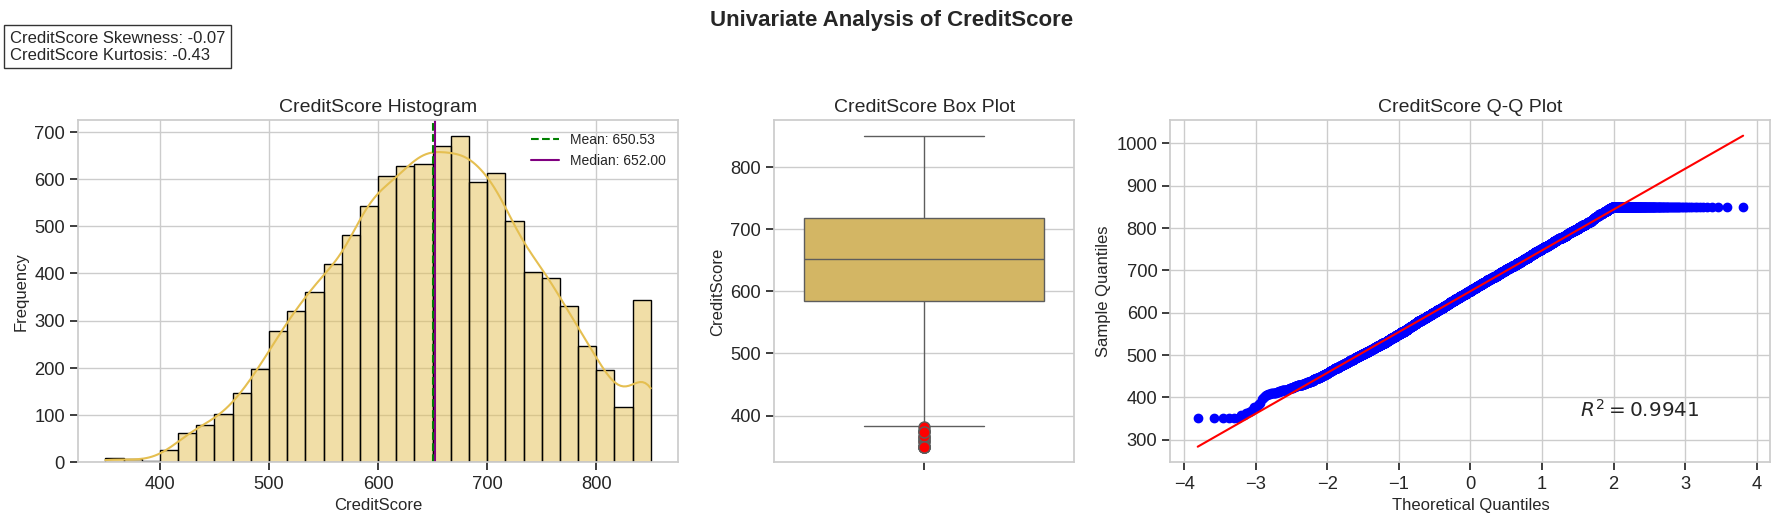

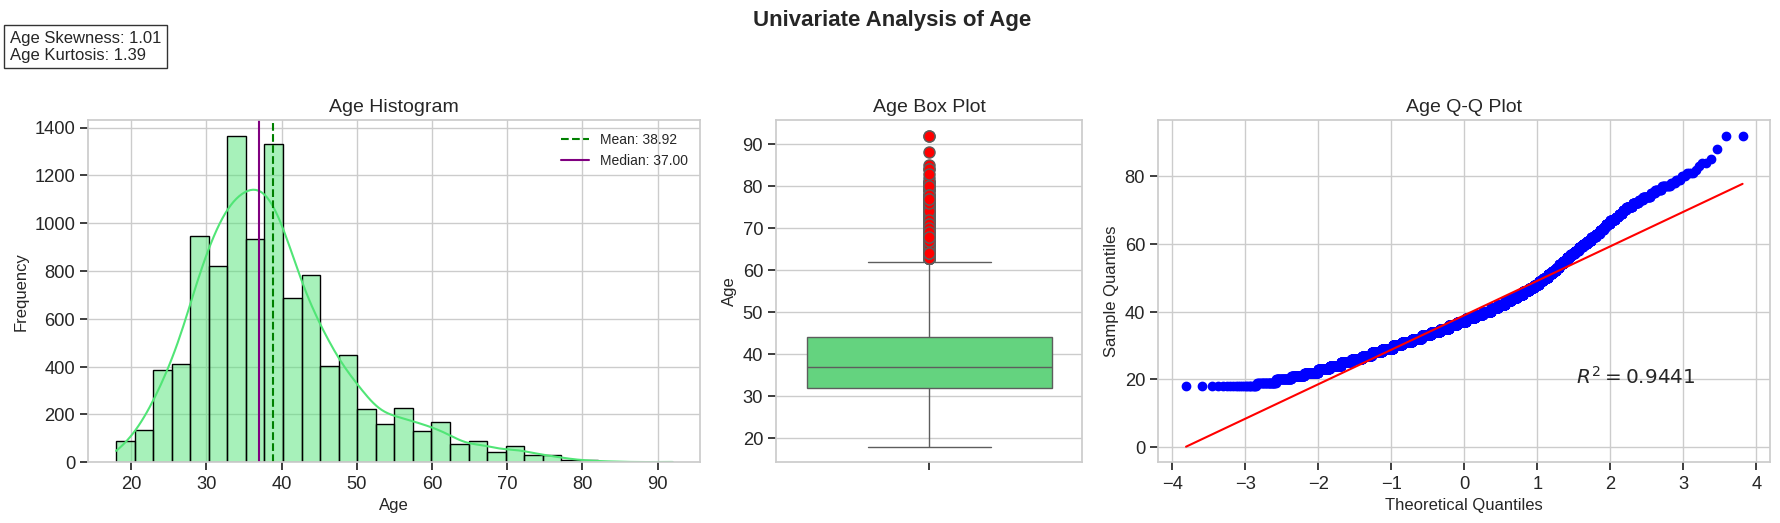

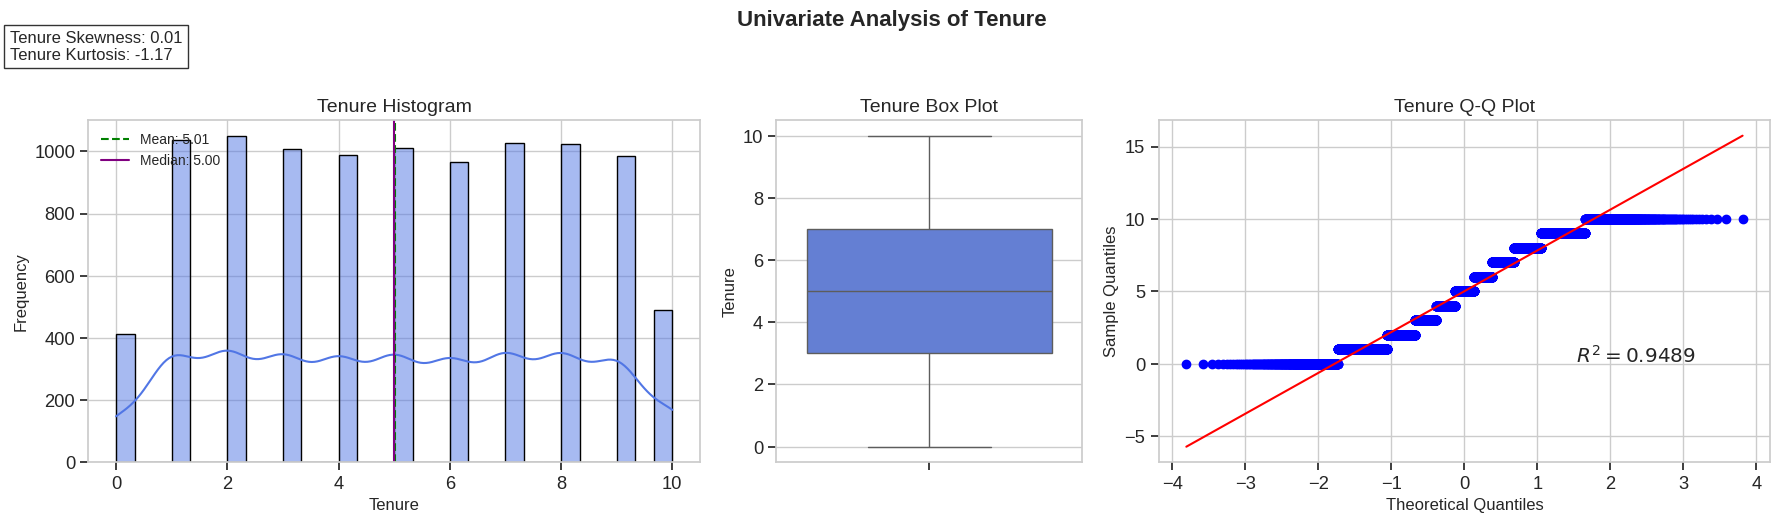

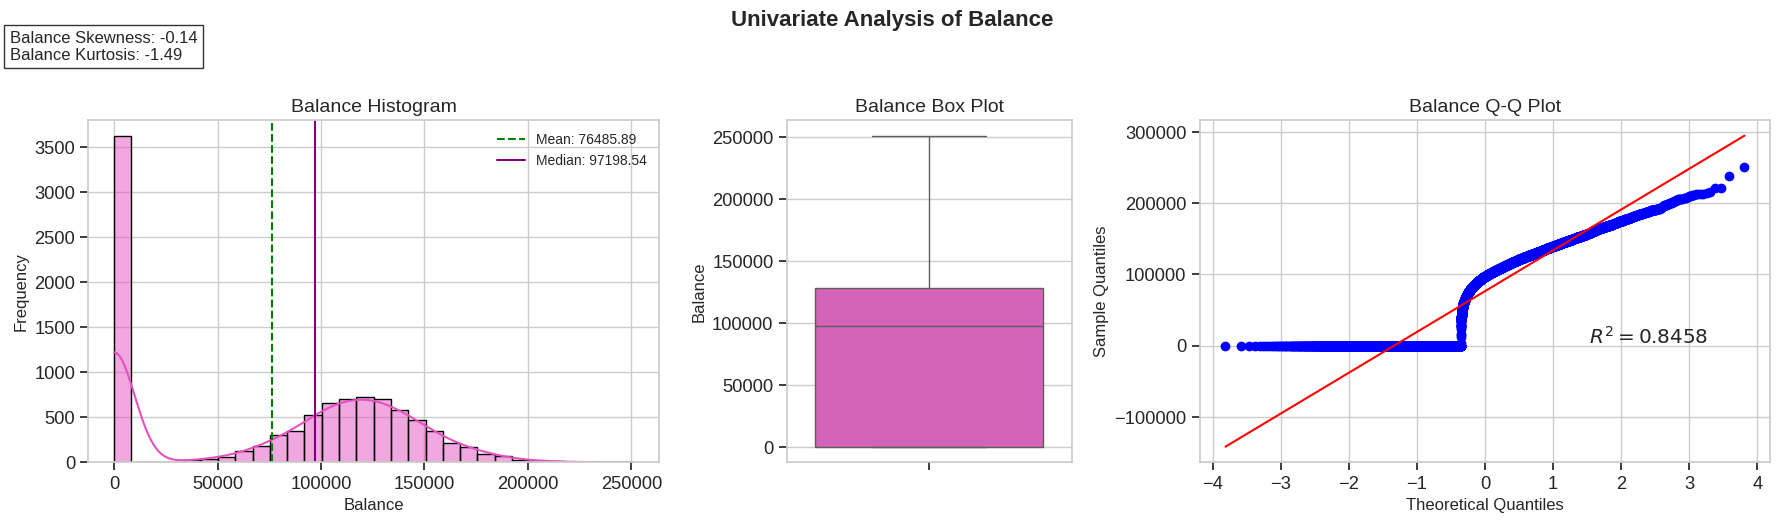

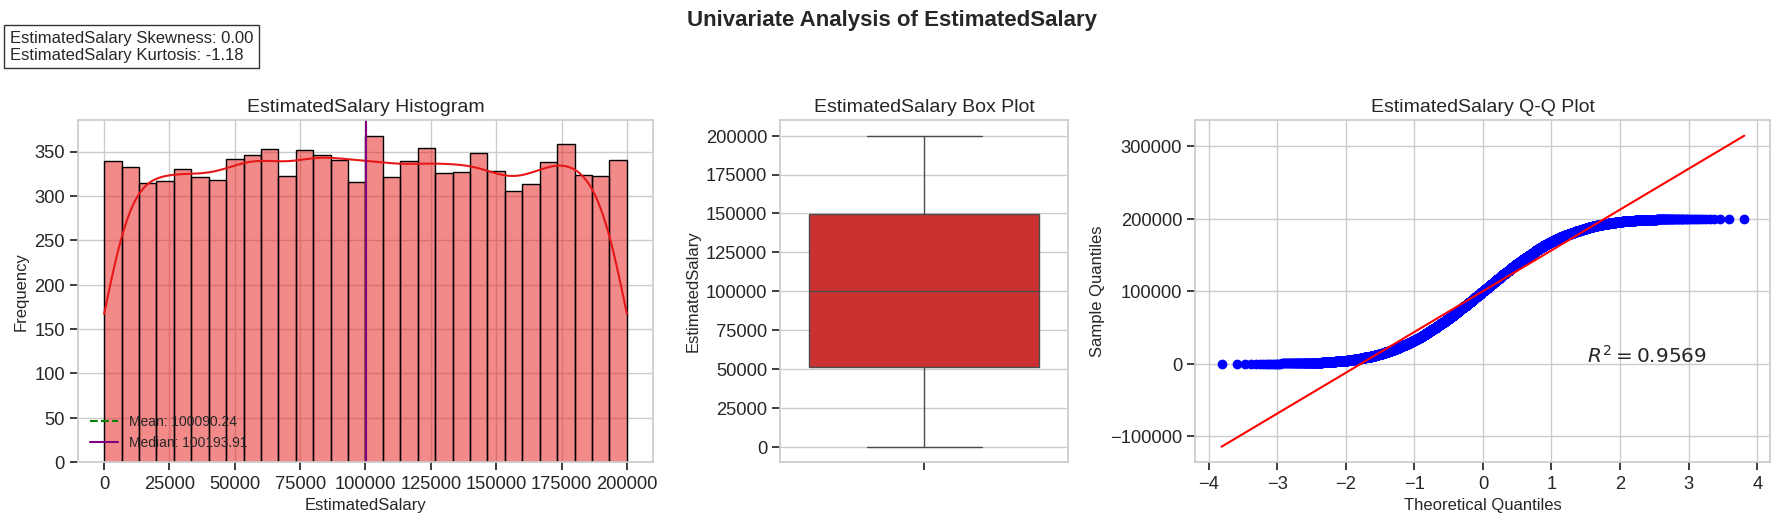

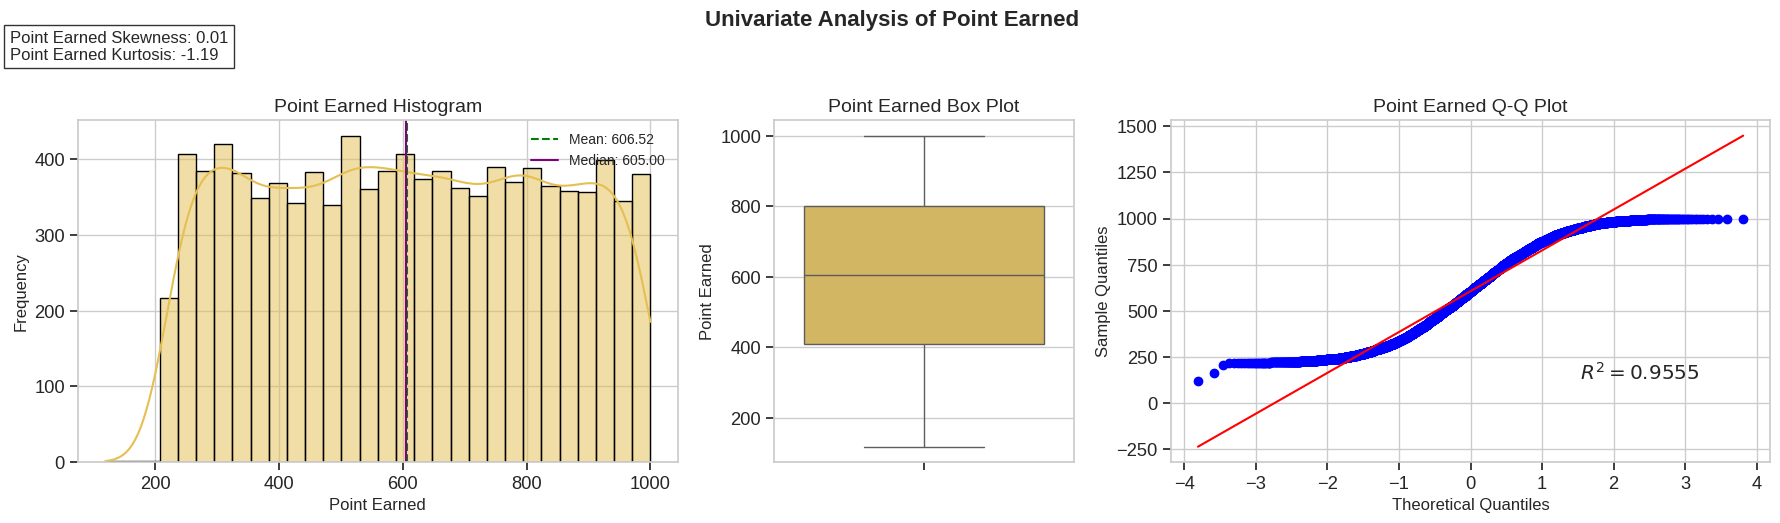

In [17]:
plot_distributions(data[numerical_cols], ordered_colors)

Numerical Features:

CreditScore: The distribution appears somewhat normal, slightly skewed to the left, indicating that more customers have higher credit scores. There are some outliers on the lower end. This is something I may fix during processing.

Age: The age distribution is right-skewed, meaning a larger proportion of customers are younger, with the majority falling between 30 and 40 years old. There are some older individuals represented as outliers.
This shows that the younger customers mostly outweigh the total customers.  THis also gives positive evidence to the data description that younger customers are more likely to churn.

Tenure: The tenure of customers appears to be fairly uniformly distributed across the years, suggesting no strong bias towards shorter or longer periods with the bank.

Balance: This feature is highly right-skewed, indicating a significant number of customers have a zero balance. For those with a balance, the distribution looks more spread out. With so many zero balance accounts, this point will definetly need to be cleaned as it brings a large skew to the data.


EstimatedSalary: The estimated salaries are quite uniformly distributed across the entire range, implying a diverse income spread among customers.

Point Earned: The points earned by customers show a distribution that is somewhat normal, with a slight left skew, suggesting most customers fall around the average points, with some leaning towards higher points.



In [18]:
def plot_categorical_features(data):

    categorical_cols = data.columns.to_list()

    plt.style.use('seaborn-v0_8')
    custom_palette = ['#3498db', '#e74c3c', '#2ecc71', '#f1c40f', '#9b59b6']  # New custom palette: blue, red, green, yellow, purple
    sns.set_palette(custom_palette)

    for col in categorical_cols:
        labels = data[col].value_counts().keys()
        counts = data[col].value_counts().values
        percentages = [f'{count} ({(count / len(data) * 100):.1f}%)' for count in counts]

        plt.figure(figsize=(6, 4))
        plt.pie(counts, labels=percentages, shadow=True,
                explode=[0.1 if i == 0 else 0 for i in range(len(labels))],
                startangle=90, textprops={'fontsize': 12, 'weight': 'bold'})

        plt.title(f'Distribution of {col}', fontsize=14, pad=20)
        plt.axis('equal')
        plt.tight_layout()
        plt.show()

        value_counts = data[col].value_counts()
        relative_freq = (data[col].value_counts(normalize=True) * 100).round(1)
        table_data = pd.DataFrame({
            'Value': value_counts.index,
            'Count': value_counts.values,
            'Relative Frequency (%)': relative_freq.values
        })
        print(tabulate(table_data, headers='keys', tablefmt='psql', showindex=False))
        print("\n")

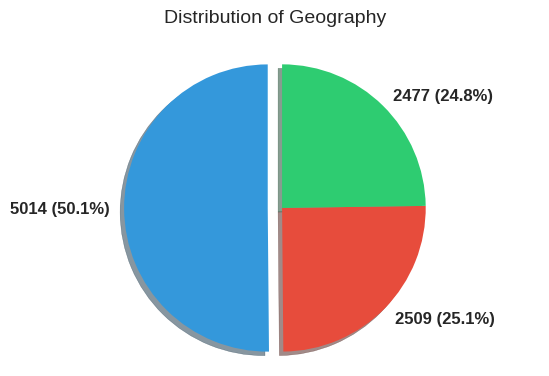

+---------+---------+--------------------------+
| Value   |   Count |   Relative Frequency (%) |
|---------+---------+--------------------------|
| France  |    5014 |                     50.1 |
| Germany |    2509 |                     25.1 |
| Spain   |    2477 |                     24.8 |
+---------+---------+--------------------------+




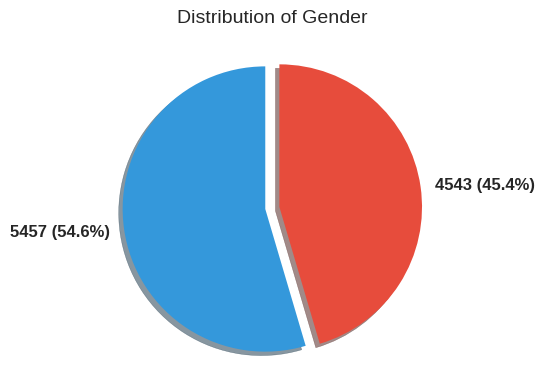

+---------+---------+--------------------------+
| Value   |   Count |   Relative Frequency (%) |
|---------+---------+--------------------------|
| Male    |    5457 |                     54.6 |
| Female  |    4543 |                     45.4 |
+---------+---------+--------------------------+




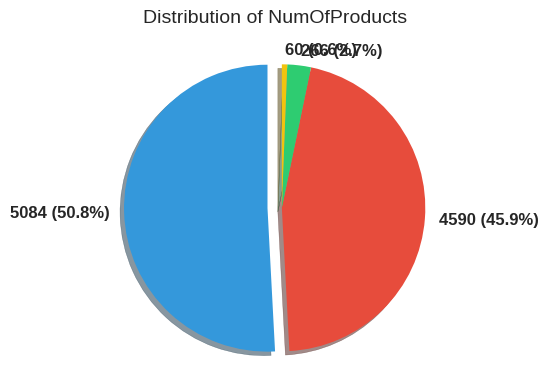

+---------+---------+--------------------------+
|   Value |   Count |   Relative Frequency (%) |
|---------+---------+--------------------------|
|       1 |    5084 |                     50.8 |
|       2 |    4590 |                     45.9 |
|       3 |     266 |                      2.7 |
|       4 |      60 |                      0.6 |
+---------+---------+--------------------------+




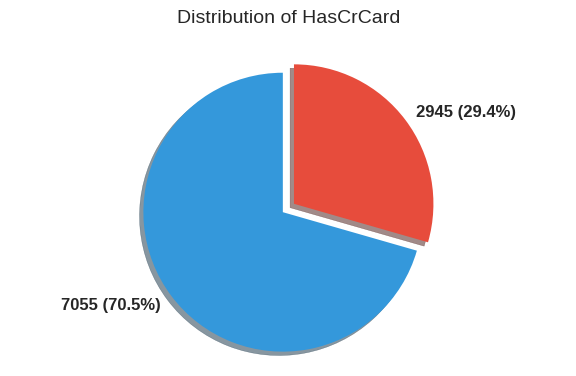

+---------+---------+--------------------------+
|   Value |   Count |   Relative Frequency (%) |
|---------+---------+--------------------------|
|       1 |    7055 |                     70.6 |
|       0 |    2945 |                     29.4 |
+---------+---------+--------------------------+




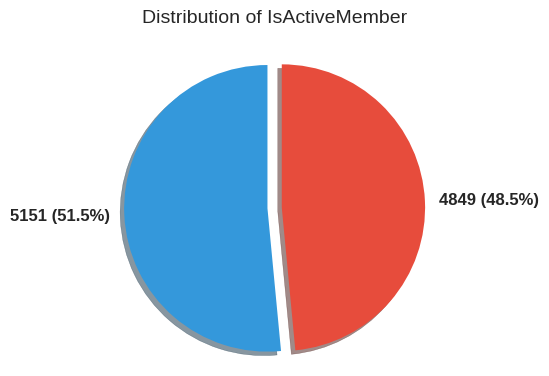

+---------+---------+--------------------------+
|   Value |   Count |   Relative Frequency (%) |
|---------+---------+--------------------------|
|       1 |    5151 |                     51.5 |
|       0 |    4849 |                     48.5 |
+---------+---------+--------------------------+




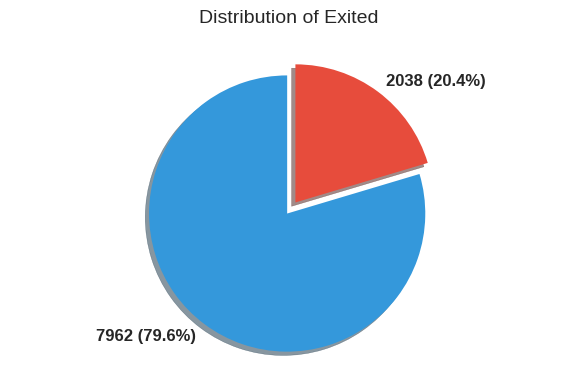

+---------+---------+--------------------------+
|   Value |   Count |   Relative Frequency (%) |
|---------+---------+--------------------------|
|       0 |    7962 |                     79.6 |
|       1 |    2038 |                     20.4 |
+---------+---------+--------------------------+




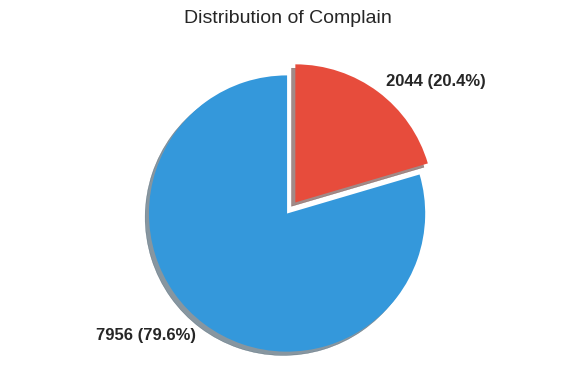

+---------+---------+--------------------------+
|   Value |   Count |   Relative Frequency (%) |
|---------+---------+--------------------------|
|       0 |    7956 |                     79.6 |
|       1 |    2044 |                     20.4 |
+---------+---------+--------------------------+




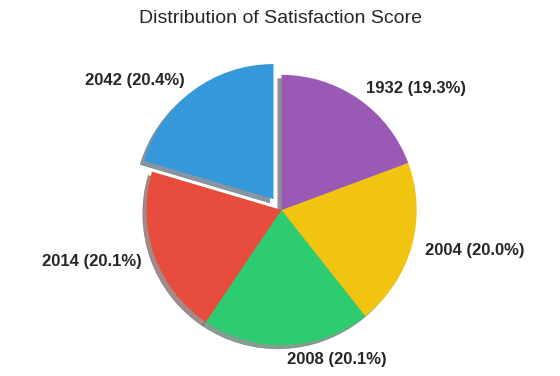

+---------+---------+--------------------------+
|   Value |   Count |   Relative Frequency (%) |
|---------+---------+--------------------------|
|       3 |    2042 |                     20.4 |
|       2 |    2014 |                     20.1 |
|       4 |    2008 |                     20.1 |
|       5 |    2004 |                     20   |
|       1 |    1932 |                     19.3 |
+---------+---------+--------------------------+




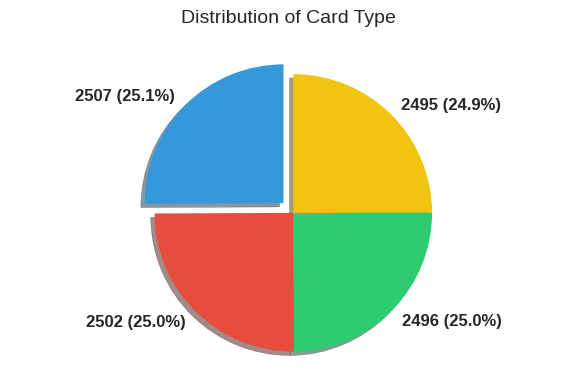

+----------+---------+--------------------------+
| Value    |   Count |   Relative Frequency (%) |
|----------+---------+--------------------------|
| DIAMOND  |    2507 |                     25.1 |
| GOLD     |    2502 |                     25   |
| SILVER   |    2496 |                     25   |
| PLATINUM |    2495 |                     25   |
+----------+---------+--------------------------+




In [19]:
plot_categorical_features(data[categorical_cols])

**Categorical Features:**

Geography: The majority of customers are from France (50.1%), followed by Germany (25.1%) and Spain (24.8%).

Gender: There's a slight majority of male customers (54.6%) compared to female customers (45.4%).

NumOfProducts: Most customers have either one (50.8%) or two (45.9%) products. Very few customers have three or four products.

HasCrCard: A large proportion of customers (70.6%) possess a credit card.

IsActiveMember: The customer base is almost evenly split between active (51.5%) and inactive (48.5%) members.

Exited: This is a key indicator of churn. Only 20.4% of customers have exited, highlighting an imbalance in the dataset towards non-churners.

Complain: Similar to 'Exited', 20.4% of customers have registered a complaint, which might be correlated with customer churn.

Satisfaction Score: Customer satisfaction scores are relatively balanced across all levels from 1 to 5, with score 3 being slightly more frequent.

Card Type: All four card types (DIAMOND, GOLD, SILVER, PLATINUM) are almost equally distributed among the customers, each representing approximately 25% of the total.

This preliminary analysis gives us a good understanding of the dataset's characteristics and potential areas to focus on for further modeling. For example, the imbalance in 'Exited' suggests that we'll need to consider techniques to handle imbalanced data when building models.

## Data Preprocessing Plan

Based on the univariate analysis, here's a plan for data preprocessing:

1.  **Outlier Treatment:** Apply Winsorization to `CreditScore`, `Age`, and `Point Earned` to cap extreme values.
2.  **Skewness Handling for 'Balance':** Apply log transformation (`np.log1p`) to normalize its distribution. Additionally, create a new binary feature `HasBalance`.
3.  **Encoding Categorical Features:** Use one-hot encoding for `Geography`, `Gender`, and `Card Type`.
4.  **Feature Scaling:** Apply `StandardScaler` to all numerical features.
5.  **Handling Imbalanced Data:** Address the imbalance in the `Exited` target variable (e.g., using SMOTE).


In [20]:
# Create a copy before modifying the data
data_processed = data.copy()

# 1. Outlier Treatment using Winsorizer
# Capping at 5th and 95th percentile
winsorizer_creditscore = Winsorizer(capping_method='iqr', fold=1.5, variables=['CreditScore'])
winsorizer_age = Winsorizer(capping_method='iqr', fold=1.5, variables=['Age'])
winsorizer_point_earned = Winsorizer(capping_method='iqr', fold=1.5, variables=['Point Earned'])

data_processed['CreditScore'] = winsorizer_creditscore.fit_transform(data_processed[['CreditScore']])['CreditScore']
data_processed['Age'] = winsorizer_age.fit_transform(data_processed[['Age']])['Age']
data_processed['Point Earned'] = winsorizer_point_earned.fit_transform(data_processed[['Point Earned']])['Point Earned']

print("Outliers treated for CreditScore, Age, and Point Earned.")

# 2. Skewness Handling for 'Balance'
# Log transform Balance
data_processed['Balance_log'] = np.log1p(data_processed['Balance'])

# Create a binary HasBalance feature
data_processed['HasBalance'] = (data_processed['Balance'] > 0).astype(int)

# Drop original Balance column if we're using Balance_log and HasBalance
data_processed.drop('Balance', axis=1, inplace=True)
print("Balance transformed and 'HasBalance' feature created.")


Outliers treated for CreditScore, Age, and Point Earned.
Balance transformed and 'HasBalance' feature created.


In [21]:
# 3. Encoding Categorical Features
categorical_features_to_encode = ['Geography', 'Gender', 'Card Type']

one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

encoded_features = one_hot_encoder.fit_transform(data_processed[categorical_features_to_encode])
encoded_df = pd.DataFrame(encoded_features, columns=one_hot_encoder.get_feature_names_out(categorical_features_to_encode))

# Drop original categorical columns and concatenate the new encoded columns
data_processed = pd.concat([data_processed.drop(columns=categorical_features_to_encode), encoded_df], axis=1)

print("Categorical features one-hot encoded.")


# Re-evaluate numerical and categorical columns after preprocessing steps
current_numerical_cols = []
current_categorical_cols = [] # These would be the remaining original categories, if any, plus binary ones

for col in data_processed.columns:
    if data_processed[col].dtype in ['int64', 'float64']:
        # Check if it's a binary column from one-hot encoding or a natural binary
        if data_processed[col].nunique() <= 2 and col not in ['Exited', 'Complain', 'HasCrCard', 'IsActiveMember'] and 'Geography_' not in col and 'Gender_' not in col and 'Card Type_' not in col: # Exclude target/known binary from general numerical scaling for now
            current_categorical_cols.append(col)
        else:
            current_numerical_cols.append(col)
    else:
        current_categorical_cols.append(col) # Should mostly be handled, but good to check

# Refine current_numerical_cols to explicitly include numerical features that need scaling
features_for_scaling = [col for col in current_numerical_cols if col not in ['Exited', 'Complain', 'HasBalance']]

# 4. Feature Scaling (for numerical features that are not binary or target)
scaler = StandardScaler()

data_processed[features_for_scaling] = scaler.fit_transform(data_processed[features_for_scaling])

print("Numerical features scaled.")

# Display the first few rows of the processed data
display(data_processed.head())
print(data_processed.info())

Categorical features one-hot encoded.
Numerical features scaled.


,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,...,HasBalance,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Card Type_DIAMOND,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER
0,-0.326221,0.342615,-1.041760,-0.911583,0.646092,0.970243,0.021886,1,1,-0.721130,...,0,0.997204,-0.578736,-0.573809,1.095988,-1.095988,1.728824,-0.577658,-0.57658,-0.576734
1,-0.440036,0.240011,-1.387538,-0.911583,-1.547768,0.970243,0.216534,0,1,-0.009816,...,1,-1.002804,-0.578736,1.742740,1.095988,-1.095988,1.728824,-0.577658,-0.57658,-0.576734
2,-1.536794,0.342615,1.032908,2.527057,0.646092,-1.030670,0.240687,1,1,-0.009816,...,1,0.997204,-0.578736,-0.573809,1.095988,-1.095988,1.728824,-0.577658,-0.57658,-0.576734
3,0.501521,0.034803,-1.387538,0.807737,-1.547768,-1.030670,-0.108918,0,0,1.412812,...,0,0.997204,-0.578736,-0.573809,1.095988,-1.095988,-0.578428,1.731128,-0.57658,-0.576734
4,2.063884,0.445219,-1.041760,-0.911583,0.646092,0.970243,-0.365276,0,0,1.412812,...,1,-1.002804,-0.578736,1.742740,1.095988,-1.095988,-0.578428,1.731128,-0.57658,-0.576734


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CreditScore         10000 non-null  float64
 1   Age                 10000 non-null  float64
 2   Tenure              10000 non-null  float64
 3   NumOfProducts       10000 non-null  float64
 4   HasCrCard           10000 non-null  float64
 5   IsActiveMember      10000 non-null  float64
 6   EstimatedSalary     10000 non-null  float64
 7   Exited              10000 non-null  int64  
 8   Complain            10000 non-null  int64  
 9   Satisfaction Score  10000 non-null  float64
 10  Point Earned        10000 non-null  float64
 11  Balance_log         10000 non-null  float64
 12  HasBalance          10000 non-null  int64  
 13  Geography_France    10000 non-null  float64
 14  Geography_Germany   10000 non-null  float64
 15  Geography_Spain     10000 non-null  float64
 16  Gende

## Bivariate Analysis: Features vs. Target Variable ('Exited')

We will now analyze the relationship between each preprocessed feature and our target variable `Exited`. This step is crucial for identifying potential predictors of customer churn.

In [22]:
# Identify the target variable
target = 'Exited'

# Separate features that were scaled and one-hot encoded from others
# We'll use the 'data_processed' DataFrame which already has these transformations

# Numerical features (after scaling and transformation, excluding original binary/target columns)
# We need to reconstruct the list of numerical columns for bivariate analysis

# Identify numerical columns that are not binary (0/1) after processing
processed_numerical_cols = [col for col in data_processed.columns if data_processed[col].dtype != 'object' and data_processed[col].nunique() > 2 and col != target and col != 'Complain']

# Identify binary/categorical columns that are not the target or Complain
# This includes the one-hot encoded columns and original binary features
processed_categorical_cols = [col for col in data_processed.columns if data_processed[col].dtype != 'object' and (data_processed[col].nunique() <= 2 or col.startswith(('Geography_', 'Gender_', 'Card Type_'))) and col != target]

print("Numerical features for bivariate analysis:", processed_numerical_cols)
print("Categorical features for bivariate analysis:", processed_categorical_cols)


Numerical features for bivariate analysis: ['CreditScore', 'Age', 'Tenure', 'NumOfProducts', 'EstimatedSalary', 'Satisfaction Score', 'Point Earned', 'Balance_log']
Categorical features for bivariate analysis: ['HasCrCard', 'IsActiveMember', 'Complain', 'HasBalance', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male', 'Card Type_DIAMOND', 'Card Type_GOLD', 'Card Type_PLATINUM', 'Card Type_SILVER']


### Bivariate Analysis: Numerical Features vs. Exited (Target)

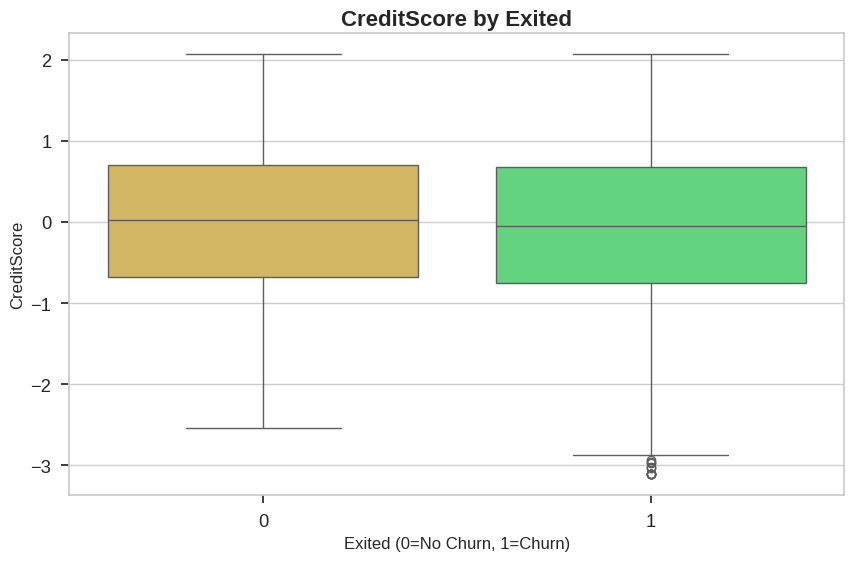

T-test for CreditScore vs Exited: t-statistic = -2.678, p-value = 0.007
  -> There is a significant difference in CreditScore between churned and non-churned customers.




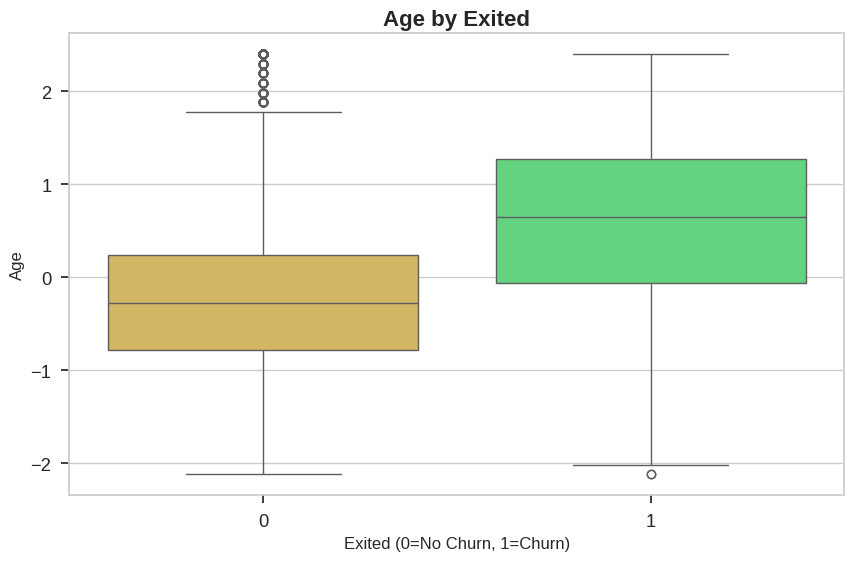

T-test for Age vs Exited: t-statistic = 32.884, p-value = 0.000
  -> There is a significant difference in Age between churned and non-churned customers.




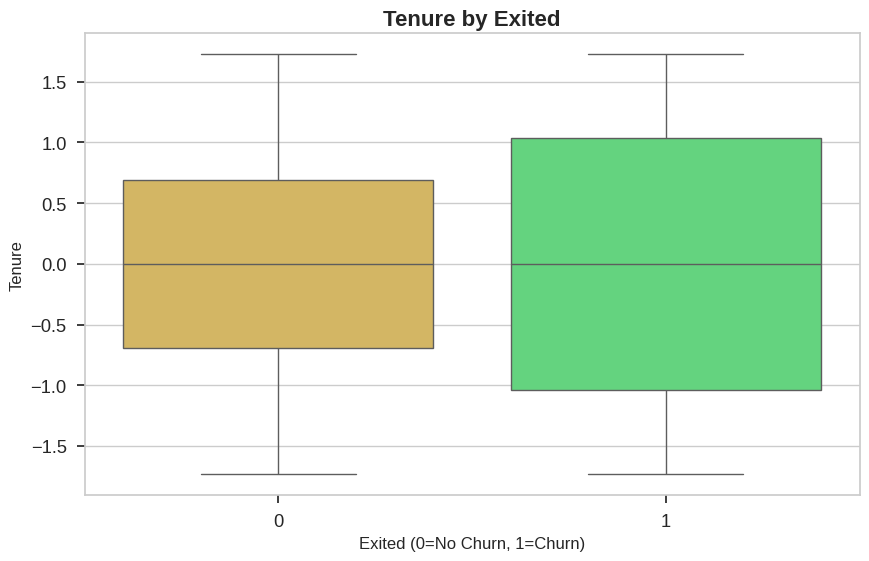

T-test for Tenure vs Exited: t-statistic = -1.366, p-value = 0.172
  -> There is no significant difference in Tenure between churned and non-churned customers.




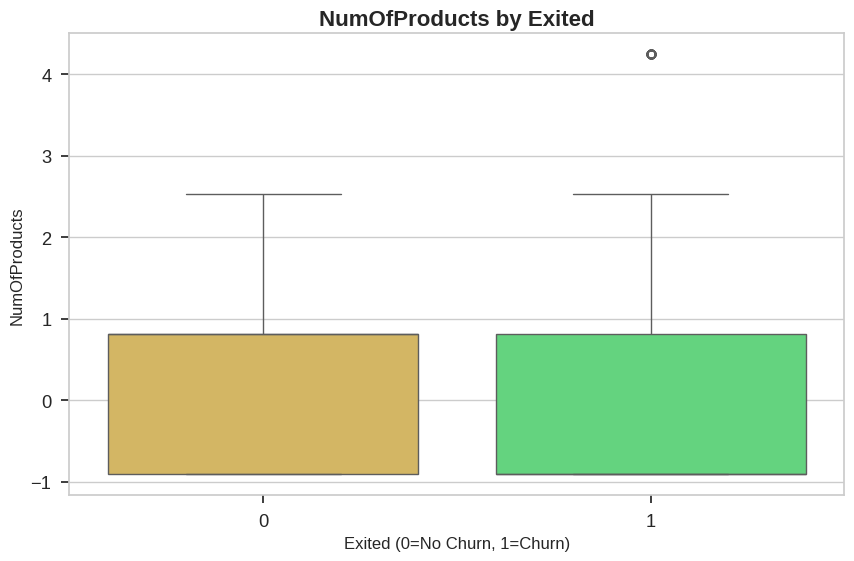

T-test for NumOfProducts vs Exited: t-statistic = -4.766, p-value = 0.000
  -> There is a significant difference in NumOfProducts between churned and non-churned customers.




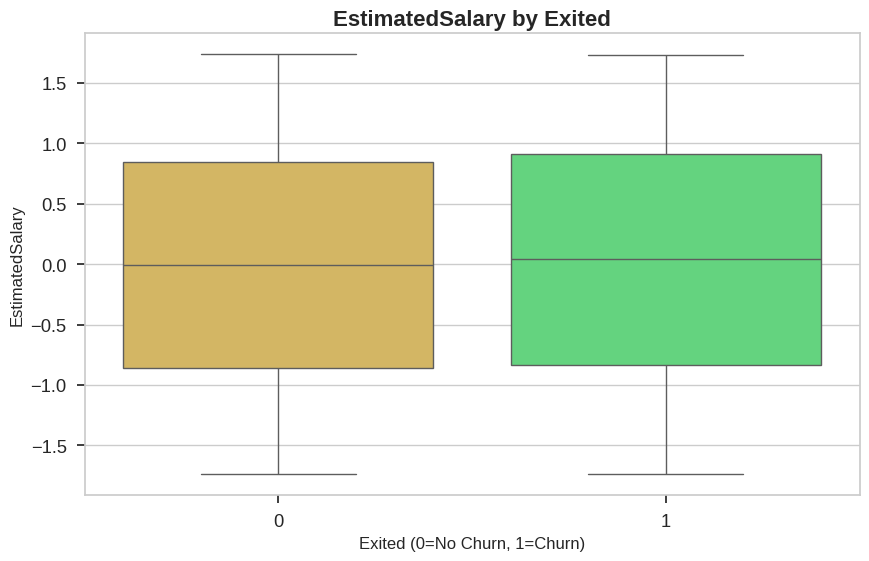

T-test for EstimatedSalary vs Exited: t-statistic = 1.249, p-value = 0.212
  -> There is no significant difference in EstimatedSalary between churned and non-churned customers.




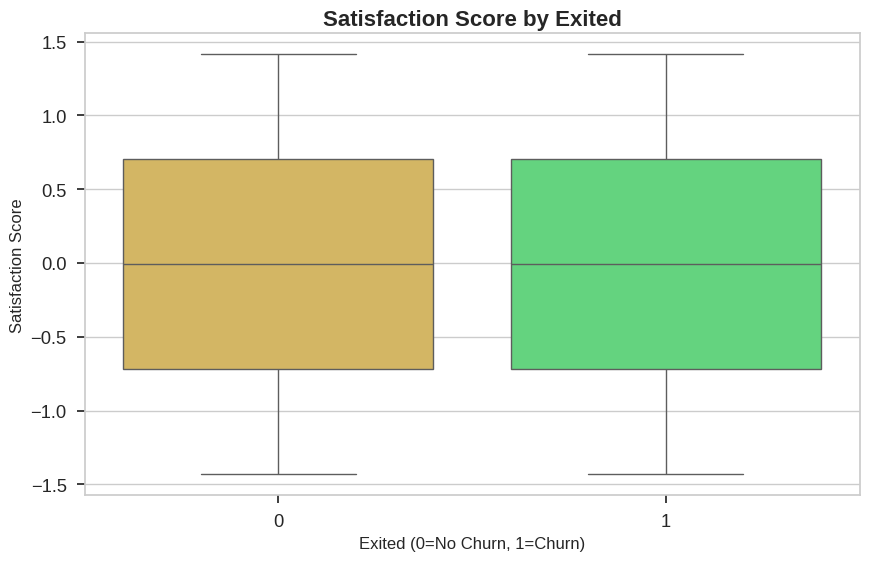

T-test for Satisfaction Score vs Exited: t-statistic = -0.585, p-value = 0.559
  -> There is no significant difference in Satisfaction Score between churned and non-churned customers.




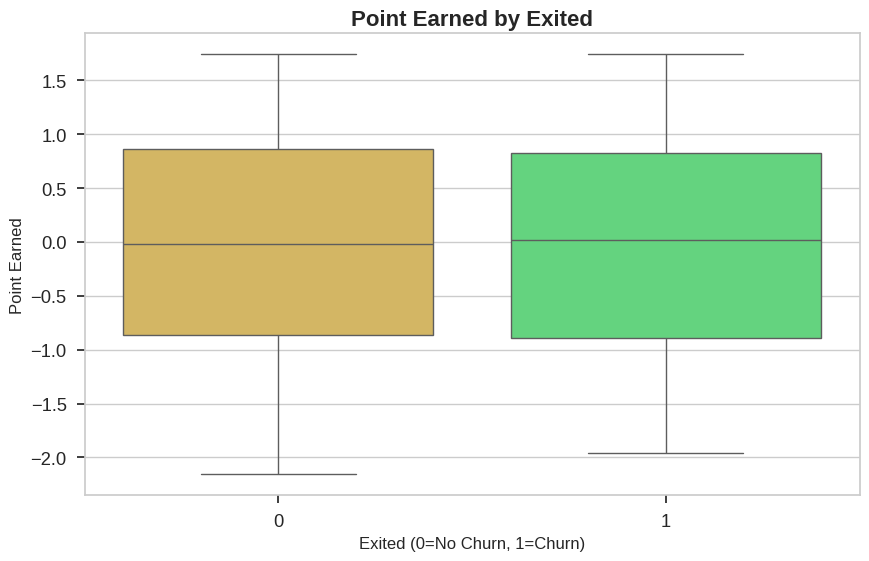

T-test for Point Earned vs Exited: t-statistic = -0.463, p-value = 0.644
  -> There is no significant difference in Point Earned between churned and non-churned customers.




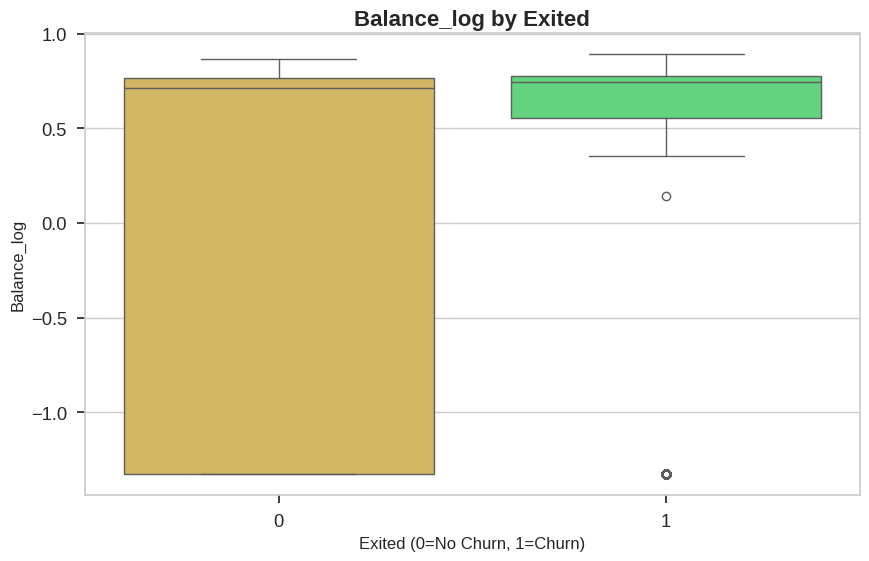

T-test for Balance_log vs Exited: t-statistic = 12.371, p-value = 0.000
  -> There is a significant difference in Balance_log between churned and non-churned customers.




In [23]:
# Plot distributions of numerical features against 'Exited'
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

for col in processed_numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=target, y=col, data=data_processed, palette=ordered_colors)
    plt.title(f'{col} by {target}', fontsize=16, weight='bold')
    plt.xlabel(f'{target} (0=No Churn, 1=Churn)', fontsize=12)
    plt.ylabel(col, fontsize=12)
    plt.show()

    # Perform T-test (or Mann-Whitney U if not normally distributed/small sample)
    # Check for normality or use non-parametric tests if assumption is violated.
    # For simplicity, we'll perform a two-sample t-test here.
    churned = data_processed[data_processed[target] == 1][col]
    not_churned = data_processed[data_processed[target] == 0][col]

    stat, p = stats.ttest_ind(churned, not_churned)
    print(f"T-test for {col} vs {target}: t-statistic = {stat:.3f}, p-value = {p:.3f}")
    if p < 0.05:
        print(f"  -> There is a significant difference in {col} between churned and non-churned customers.")
    else:
        print(f"  -> There is no significant difference in {col} between churned and non-churned customers.")
    print("\n")


### Bivariate Analysis: Categorical Features vs. Exited (Target)

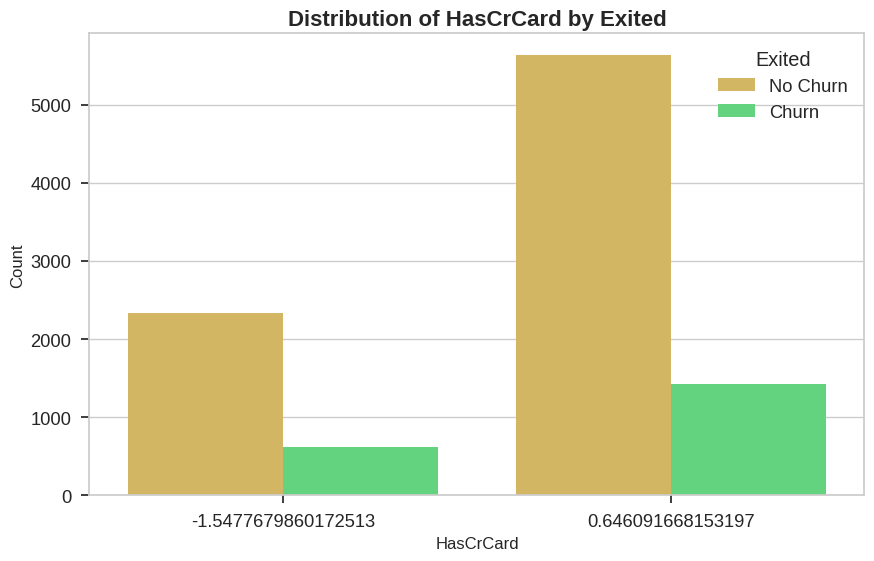

Chi-squared test for HasCrCard vs Exited: Chi2 = 0.449, p-value = 0.503
  -> There is no significant association between HasCrCard and Exited.




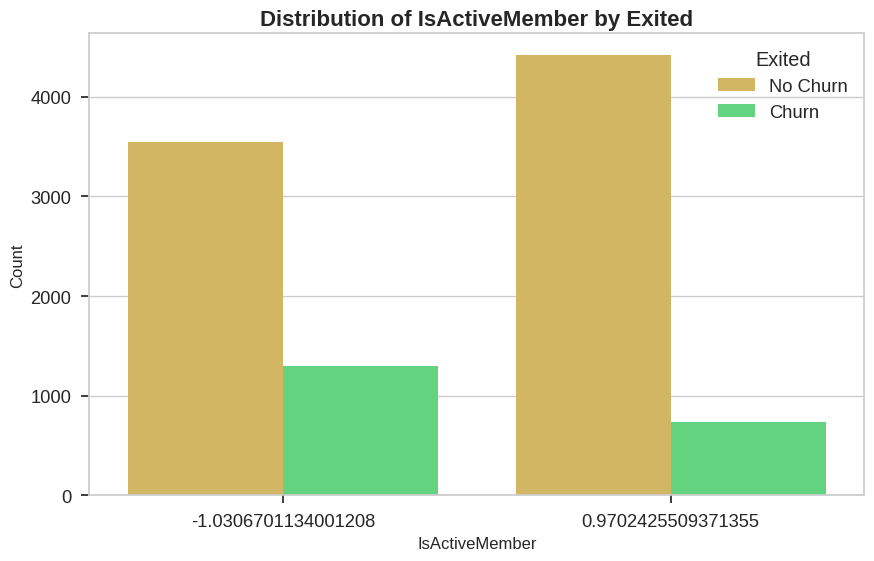

Chi-squared test for IsActiveMember vs Exited: Chi2 = 243.695, p-value = 0.000
  -> There is a significant association between IsActiveMember and Exited.




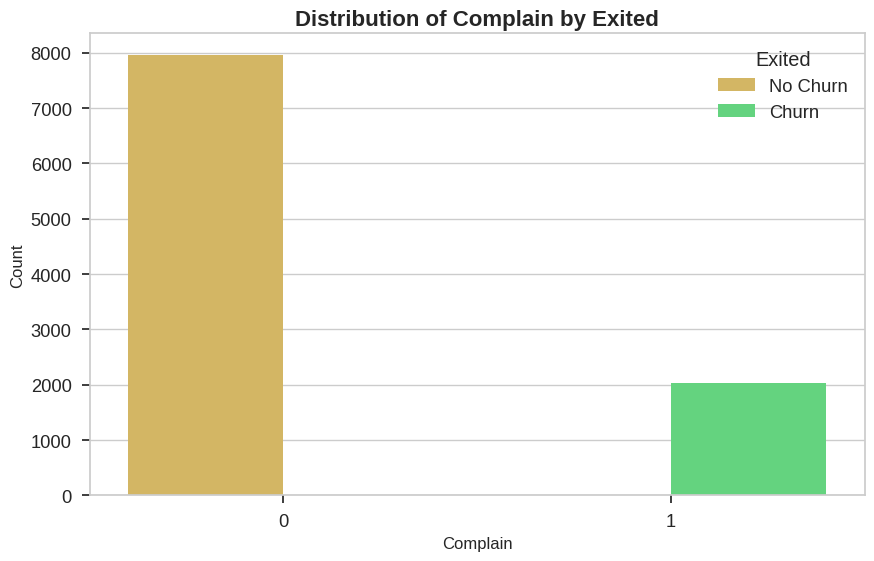

Chi-squared test for Complain vs Exited: Chi2 = 9907.907, p-value = 0.000
  -> There is a significant association between Complain and Exited.




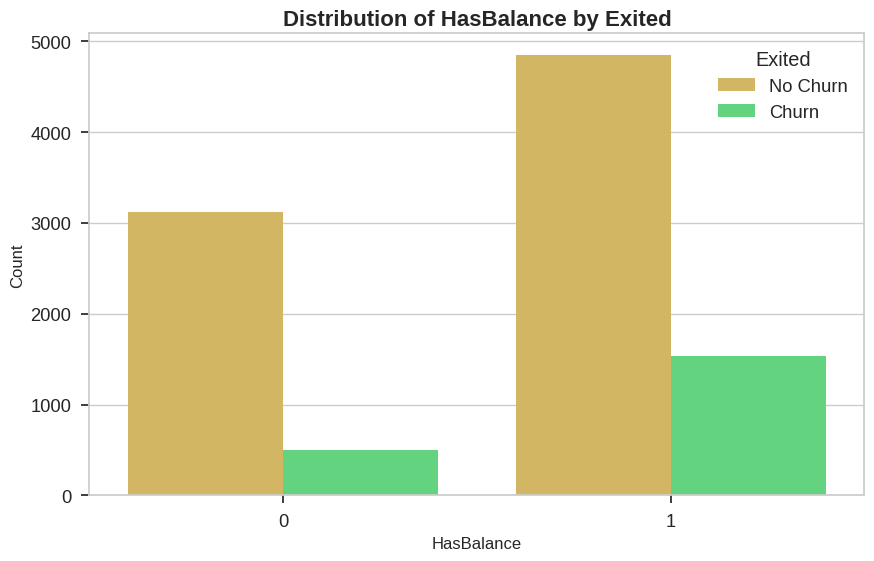

Chi-squared test for HasBalance vs Exited: Chi2 = 149.484, p-value = 0.000
  -> There is a significant association between HasBalance and Exited.




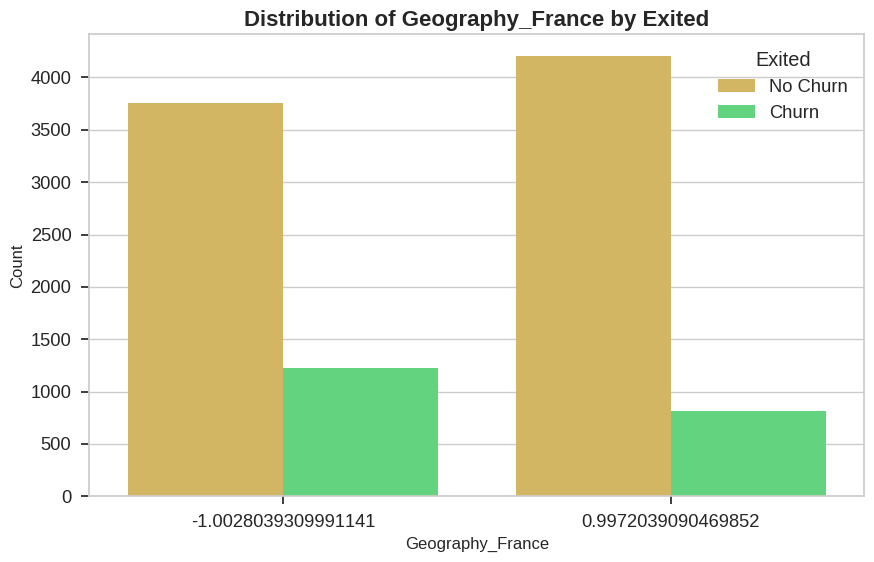

Chi-squared test for Geography_France vs Exited: Chi2 = 109.078, p-value = 0.000
  -> There is a significant association between Geography_France and Exited.




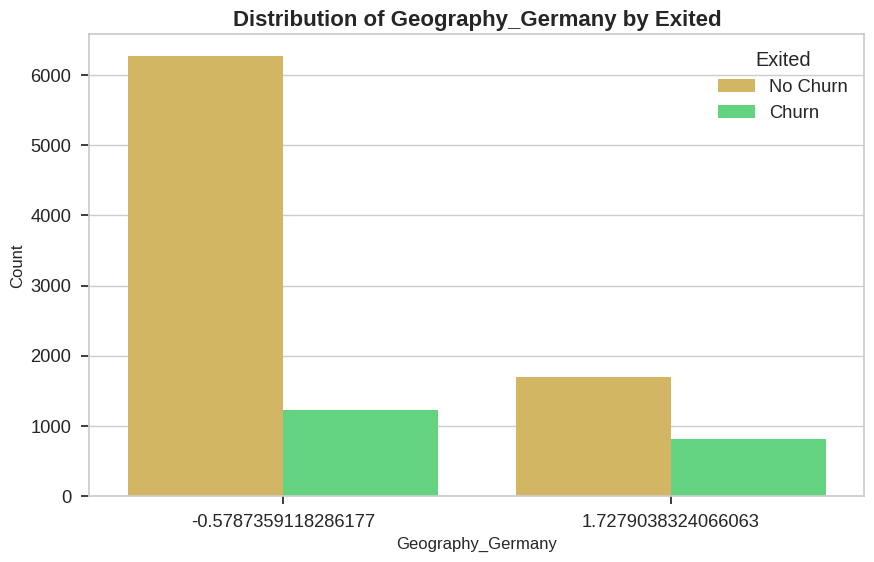

Chi-squared test for Geography_Germany vs Exited: Chi2 = 299.381, p-value = 0.000
  -> There is a significant association between Geography_Germany and Exited.




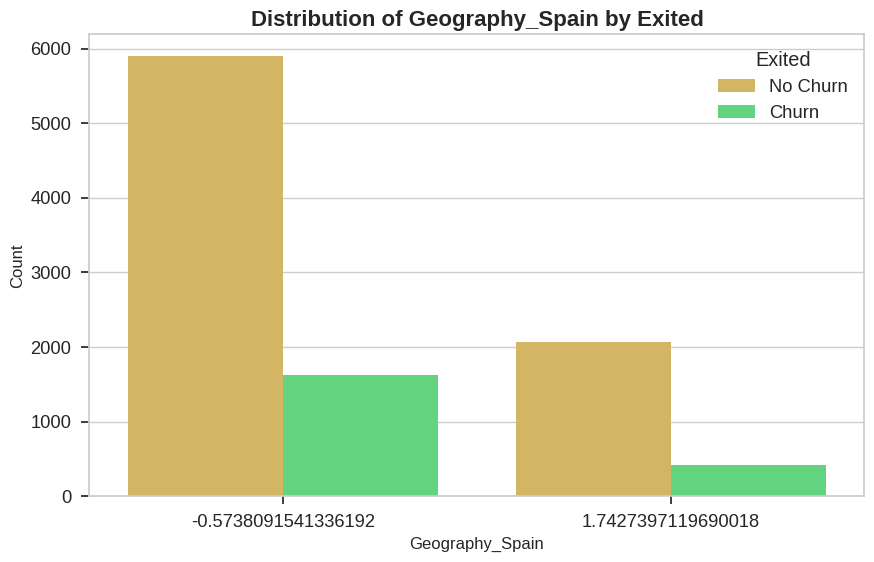

Chi-squared test for Geography_Spain vs Exited: Chi2 = 27.575, p-value = 0.000
  -> There is a significant association between Geography_Spain and Exited.




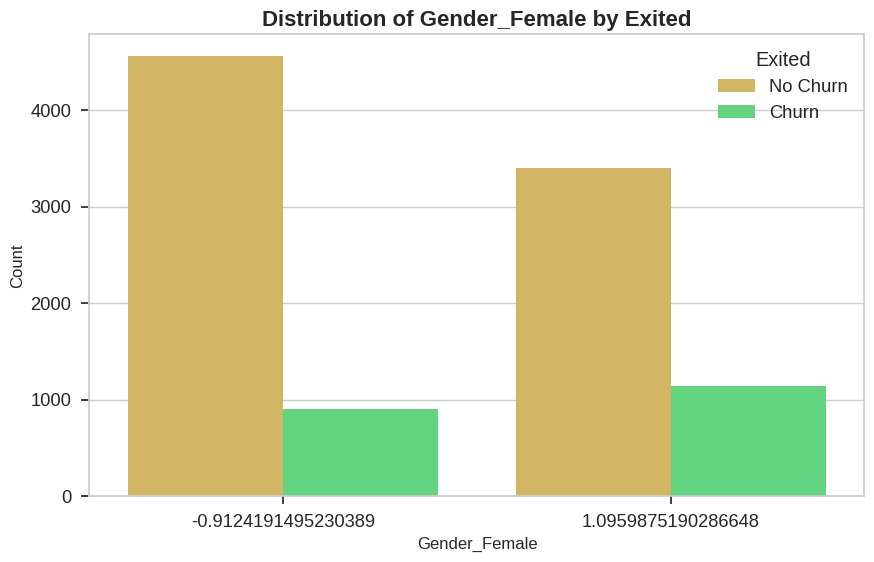

Chi-squared test for Gender_Female vs Exited: Chi2 = 112.397, p-value = 0.000
  -> There is a significant association between Gender_Female and Exited.




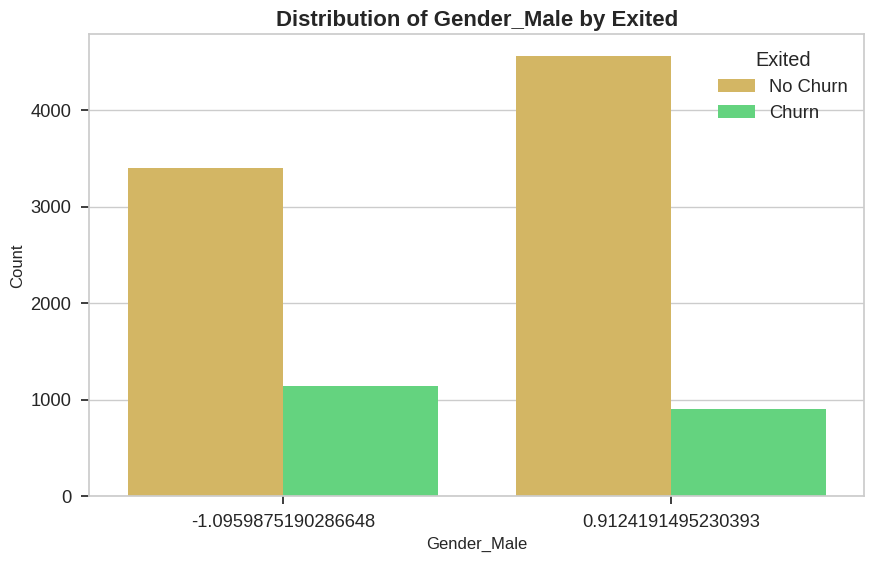

Chi-squared test for Gender_Male vs Exited: Chi2 = 112.397, p-value = 0.000
  -> There is a significant association between Gender_Male and Exited.




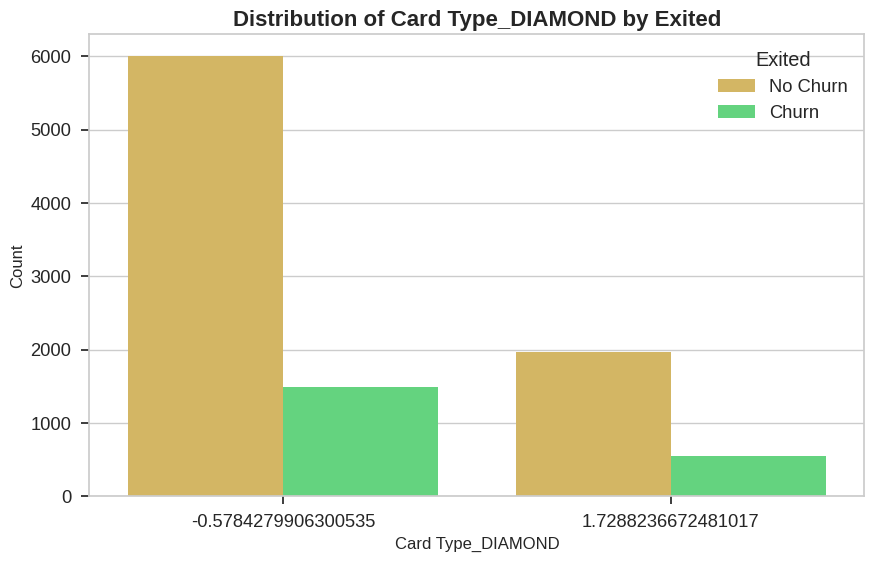

Chi-squared test for Card Type_DIAMOND vs Exited: Chi2 = 3.921, p-value = 0.048
  -> There is a significant association between Card Type_DIAMOND and Exited.




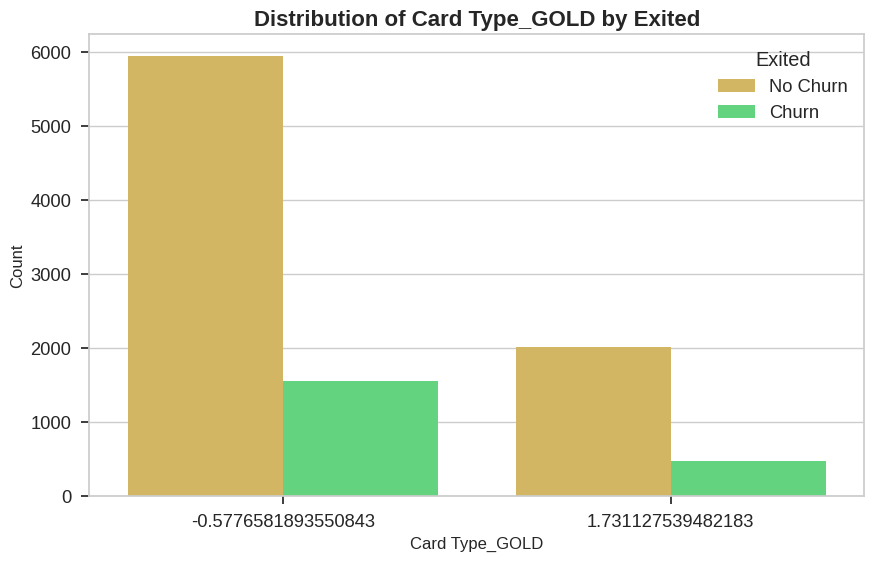

Chi-squared test for Card Type_GOLD vs Exited: Chi2 = 2.468, p-value = 0.116
  -> There is no significant association between Card Type_GOLD and Exited.




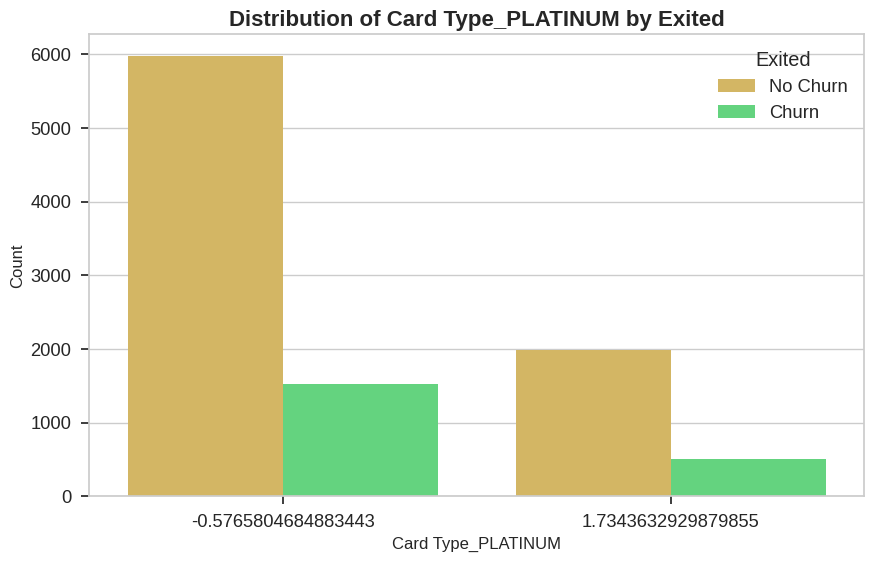

Chi-squared test for Card Type_PLATINUM vs Exited: Chi2 = 0.000, p-value = 1.000
  -> There is no significant association between Card Type_PLATINUM and Exited.




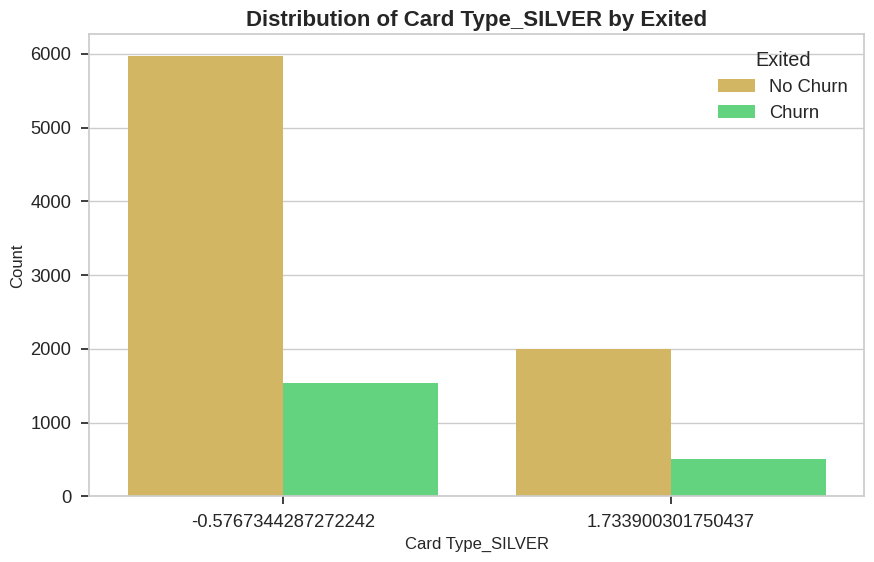

Chi-squared test for Card Type_SILVER vs Exited: Chi2 = 0.126, p-value = 0.723
  -> There is no significant association between Card Type_SILVER and Exited.




In [24]:
# Plot countplots for categorical features against 'Exited'
for col in processed_categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, hue=target, data=data_processed, palette=ordered_colors)
    plt.title(f'Distribution of {col} by {target}', fontsize=16, weight='bold')
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend(title=target, labels=['No Churn', 'Churn'])
    plt.show()

    # Perform Chi-squared test for independence
    contingency_table = pd.crosstab(data_processed[col], data_processed[target])
    chi2, p, _, _ = stats.chi2_contingency(contingency_table)
    print(f"Chi-squared test for {col} vs {target}: Chi2 = {chi2:.3f}, p-value = {p:.3f}")
    if p < 0.05:
        print(f"  -> There is a significant association between {col} and {target}.")
    else:
        print(f"  -> There is no significant association between {col} and {target}.")
    print("\n")


# Task
The bivariate analysis with the `Exited` target variable revealed the following statistically significant features (p-value < 0.05):

**Significant Numerical Features:**
*   `CreditScore`
*   `Age`
*   `NumOfProducts`
*   `Balance_log`

**Significant Categorical Features:**
*   `IsActiveMember`
*   `Complain`
*   `HasBalance`
*   `Geography_France`
*   `Geography_Germany`
*   `Geography_Spain`
*   `Gender_Female`
*   `Gender_Male`
*   `Card Type_DIAMOND`

These features will be used for building our predictive models.

Now, let's prepare the data for modeling:
1.  Separate the features (X) from the target variable (y = 'Exited').
2.  Split the dataset into training and testing sets (e.g., 80% training, 20% testing).
3.  Address the class imbalance in the target variable using SMOTE on the training data.

## Prepare Data for Modeling

### Subtask:
Separate features (X) from the target variable (y = 'Exited'), split the dataset into training and testing sets, and address class imbalance using SMOTE on the training data.


**Reasoning**:
The first step is to import the SMOTE library, which is necessary for handling class imbalance as specified in the instructions. This import needs to happen before SMOTE can be used.



In [25]:
from imblearn.over_sampling import SMOTE
print("SMOTE imported successfully.")

SMOTE imported successfully.


**Reasoning**:
The next logical step is to perform the data preparation for modeling as per the instructions: separating features and target, splitting the data, and applying SMOTE. This involves defining the significant features, creating X and y, splitting them into training and testing sets, and then using SMOTE on the training data to address class imbalance.



In [26]:
significant_features = [
    'CreditScore',
    'Age',
    'NumOfProducts',
    'Balance_log',
    'IsActiveMember',
    'Complain',
    'HasBalance',
    'Geography_France',
    'Geography_Germany',
    'Geography_Spain',
    'Gender_Female',
    'Gender_Male',
    'Card Type_DIAMOND'
]

X = data_processed[significant_features]
y = data_processed['Exited']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Original training set shape: {X_train.shape}, {y_train.shape}")
print(f"Resampled training set shape: {X_train_resampled.shape}, {y_train_resampled.shape}")
print(f"Original target distribution (training):\n{y_train.value_counts(normalize=True)}")
print(f"Resampled target distribution (training):\n{y_train_resampled.value_counts(normalize=True)}")
print("Data separated, split, and SMOTE applied to training data.")

Original training set shape: (8000, 13), (8000,)
Resampled training set shape: (12740, 13), (12740,)
Original target distribution (training):
Exited
0    0.79625
1    0.20375
Name: proportion, dtype: float64
Resampled target distribution (training):
Exited
0    0.5
1    0.5
Name: proportion, dtype: float64
Data separated, split, and SMOTE applied to training data.


## Train Classification Models

### Subtask:
Train several classification models suitable for binary classification (e.g., Logistic Regression, Decision Tree, Random Forest, Gradient Boosting, XGBoost, K-Nearest Neighbors) on the preprocessed and balanced training data. Focus on baseline performance first.


**Reasoning**:
The subtask requires initializing and training multiple classification models using the preprocessed and balanced training data. This step consolidates the training of Logistic Regression, K-Nearest Neighbors, Decision Tree, Random Forest, AdaBoost, Gradient Boosting, and XGBoost models as specified in the instructions.



In [27]:
print('Training Logistic Regression model...')
log_reg_model = LogisticRegression(random_state=42, solver='liblinear')
log_reg_model.fit(X_train_resampled, y_train_resampled)
print('Logistic Regression model trained.')

print('Training K-Nearest Neighbors model...')
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_resampled, y_train_resampled)
print('K-Nearest Neighbors model trained.')

print('Training Decision Tree Classifier model...')
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_resampled, y_train_resampled)
print('Decision Tree Classifier model trained.')

print('Training Random Forest Classifier model...')
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)
print('Random Forest Classifier model trained.')

print('Training AdaBoost Classifier model...')
ada_model = AdaBoostClassifier(random_state=42)
ada_model.fit(X_train_resampled, y_train_resampled)
print('AdaBoost Classifier model trained.')

print('Training Gradient Boosting Classifier model...')
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_resampled, y_train_resampled)
print('Gradient Boosting Classifier model trained.')

print('Training XGBoost Classifier model...')
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_resampled, y_train_resampled)
print('XGBoost Classifier model trained.')

Training Logistic Regression model...
Logistic Regression model trained.
Training K-Nearest Neighbors model...
K-Nearest Neighbors model trained.
Training Decision Tree Classifier model...
Decision Tree Classifier model trained.
Training Random Forest Classifier model...
Random Forest Classifier model trained.
Training AdaBoost Classifier model...
AdaBoost Classifier model trained.
Training Gradient Boosting Classifier model...
Gradient Boosting Classifier model trained.
Training XGBoost Classifier model...
XGBoost Classifier model trained.


## Evaluate Model Performance

### Subtask:
Evaluate the trained models on the test set using appropriate classification metrics such as Accuracy, Precision, Recall, F1-Score, and AUC-ROC. Analyze confusion matrices to understand model strengths and weaknesses, especially concerning the minority class (churned customers).


**Reasoning**:
To evaluate the performance of each trained model, I will create a loop that iterates through all models. Inside the loop, I will make predictions, calculate various classification metrics, generate confusion matrices, and print classification reports as specified in the instructions. This consolidates all evaluation steps into a single, executable block.




Evaluating Logistic Regression:
Accuracy: 0.9985
Precision: 0.9975
Recall: 0.9951
F1-Score: 0.9963
AUC-ROC: 0.9984


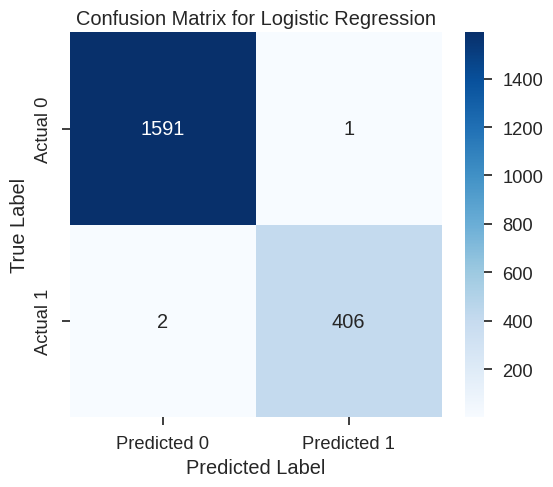

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       1.00      1.00      1.00       408

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


Evaluating K-Nearest Neighbors:
Accuracy: 0.9765
Precision: 0.9370
Recall: 0.9485
F1-Score: 0.9428
AUC-ROC: 0.9814


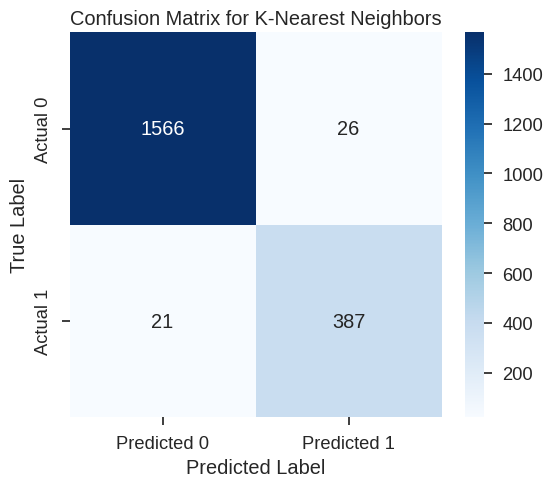

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1592
           1       0.94      0.95      0.94       408

    accuracy                           0.98      2000
   macro avg       0.96      0.97      0.96      2000
weighted avg       0.98      0.98      0.98      2000


Evaluating Decision Tree:
Accuracy: 0.9965
Precision: 0.9902
Recall: 0.9926
F1-Score: 0.9914
AUC-ROC: 0.9951


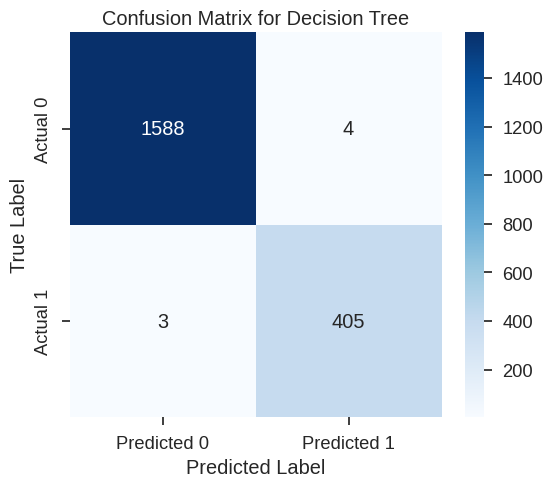

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       0.99      0.99      0.99       408

    accuracy                           1.00      2000
   macro avg       0.99      1.00      0.99      2000
weighted avg       1.00      1.00      1.00      2000


Evaluating Random Forest:
Accuracy: 0.9985
Precision: 0.9975
Recall: 0.9951
F1-Score: 0.9963
AUC-ROC: 0.9990


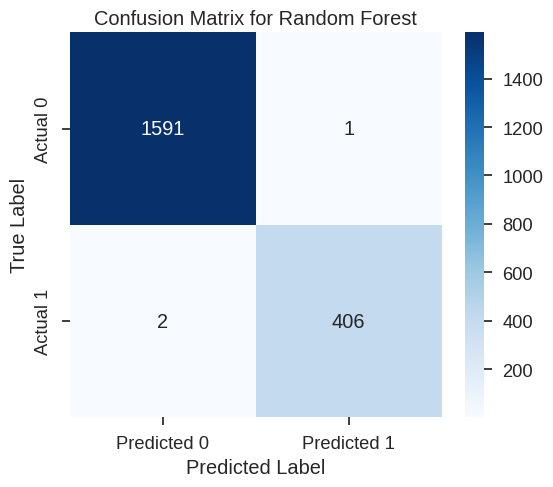

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       1.00      1.00      1.00       408

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


Evaluating AdaBoost:
Accuracy: 0.9985
Precision: 0.9975
Recall: 0.9951
F1-Score: 0.9963
AUC-ROC: 0.9984


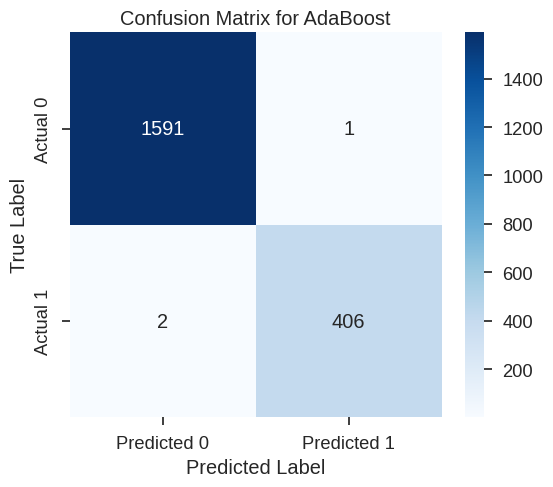

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       1.00      1.00      1.00       408

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


Evaluating Gradient Boosting:
Accuracy: 0.9985
Precision: 0.9975
Recall: 0.9951
F1-Score: 0.9963
AUC-ROC: 0.9986


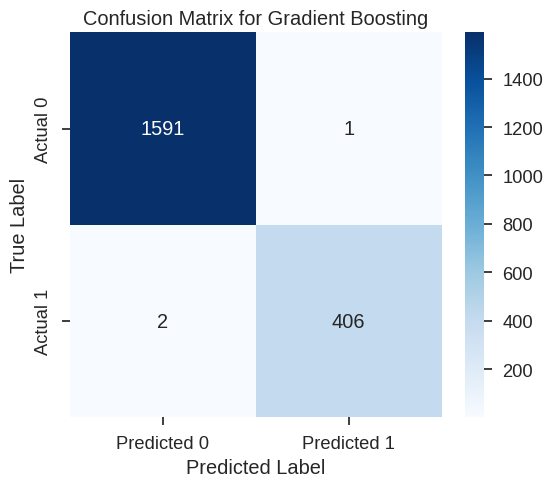

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       1.00      1.00      1.00       408

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


Evaluating XGBoost:
Accuracy: 0.9985
Precision: 0.9975
Recall: 0.9951
F1-Score: 0.9963
AUC-ROC: 0.9982


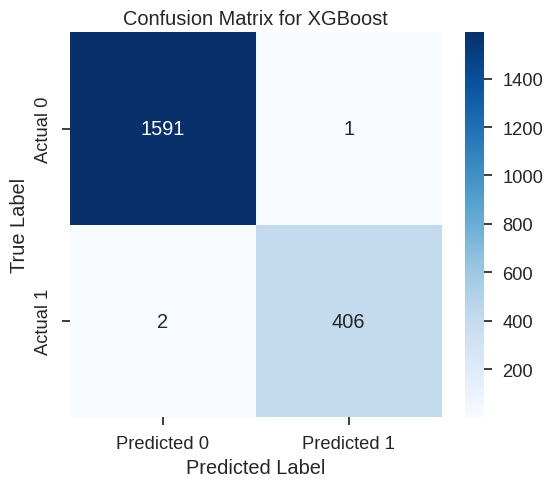

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       1.00      1.00      1.00       408

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Create a list of the trained models
models = {
    'Logistic Regression': log_reg_model,
    'K-Nearest Neighbors': knn_model,
    'Decision Tree': dt_model,
    'Random Forest': rf_model,
    'AdaBoost': ada_model,
    'Gradient Boosting': gb_model,
    'XGBoost': xgb_model
}

# Iterate through each model and evaluate
for name, model in models.items():
    print(f"\nEvaluating {name}:")

    # 3. Make predictions on the X_test data
    y_pred = model.predict(X_test)

    # 4. Get probability of the positive class for AUC-ROC
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = y_pred # For models without predict_proba, use binary predictions (will affect AUC-ROC accuracy)

    # 6. Calculate and print Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # 7. Calculate and print Precision
    precision = precision_score(y_test, y_pred)
    print(f"Precision: {precision:.4f}")

    # 8. Calculate and print Recall
    recall = recall_score(y_test, y_pred)
    print(f"Recall: {recall:.4f}")

    # 9. Calculate and print F1-Score
    f1 = f1_score(y_test, y_pred)
    print(f"F1-Score: {f1:.4f}")

    # 10. Calculate and print AUC-ROC Score
    try:
        auc_roc = roc_auc_score(y_test, y_pred_proba)
        print(f"AUC-ROC: {auc_roc:.4f}")
    except ValueError:
        print("AUC-ROC cannot be calculated for this model or its predictions.")

    # 11. Generate and display the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # 12. Print a classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


## Hyperparameter Tuning and Selection

### Subtask:
Select the best performing model(s) and perform hyperparameter tuning using techniques like GridSearchCV or RandomizedSearchCV to optimize their performance further. Choose the final model based on evaluation metrics relevant to the business problem (e.g., high recall if minimizing false negatives is crucial for churn prevention).


**Reasoning**:
Based on the evaluation metrics from the previous step, Logistic Regression, Random Forest, and Gradient Boosting models showed excellent performance. I will select these three for hyperparameter tuning, defining specific parameter grids for each to optimize their performance further using `GridSearchCV`.



In [29]:
from sklearn.model_selection import GridSearchCV

# Define parameter grids for the selected models

# 1. Logistic Regression
param_grid_log_reg = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'penalty': ['l1', 'l2']
}

# 2. Random Forest Classifier
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 3. Gradient Boosting Classifier
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 8]
}

# Initialize GridSearchCV for each model

print("Performing GridSearchCV for Logistic Regression...")
grid_search_log_reg = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid_log_reg,
    cv=5,
    scoring='recall', # Prioritize recall for churn prediction
    n_jobs=-1,
    verbose=1
)
grid_search_log_reg.fit(X_train_resampled, y_train_resampled)
print("Logistic Regression GridSearchCV complete.")

print("Performing GridSearchCV for Random Forest...")
grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)
grid_search_rf.fit(X_train_resampled, y_train_resampled)
print("Random Forest GridSearchCV complete.")

print("Performing GridSearchCV for Gradient Boosting...")
grid_search_gb = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid_gb,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)
grid_search_gb.fit(X_train_resampled, y_train_resampled)
print("Gradient Boosting GridSearchCV complete.")

# Store the best models
best_log_reg_model = grid_search_log_reg.best_estimator_
best_rf_model = grid_search_rf.best_estimator_
best_gb_model = grid_search_gb.best_estimator_

print("Best parameters for Logistic Regression:", grid_search_log_reg.best_params_)
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best parameters for Gradient Boosting:", grid_search_gb.best_params_)

Performing GridSearchCV for Logistic Regression...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Logistic Regression GridSearchCV complete.
Performing GridSearchCV for Random Forest...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Random Forest GridSearchCV complete.
Performing GridSearchCV for Gradient Boosting...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Gradient Boosting GridSearchCV complete.
Best parameters for Logistic Regression: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


**Reasoning**:
Now that the hyperparameter tuning for Logistic Regression, Random Forest, and Gradient Boosting is complete, I will evaluate these best-tuned models on the test set. This involves making predictions, calculating various classification metrics (Accuracy, Precision, Recall, F1-Score, AUC-ROC), displaying confusion matrices, and printing classification reports to comprehensively assess their performance as outlined in the instructions.




Evaluating Tuned Logistic Regression (Tuned Model):
Accuracy: 0.9985
Precision: 0.9975
Recall: 0.9951
F1-Score: 0.9963
AUC-ROC: 0.9978


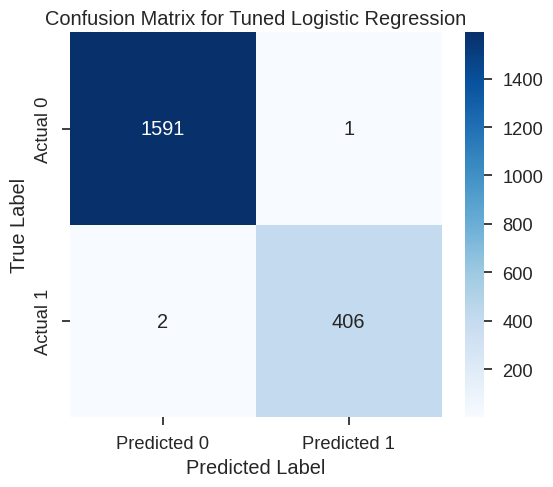

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       1.00      1.00      1.00       408

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


Evaluating Tuned Random Forest (Tuned Model):
Accuracy: 0.9985
Precision: 0.9975
Recall: 0.9951
F1-Score: 0.9963
AUC-ROC: 0.9992


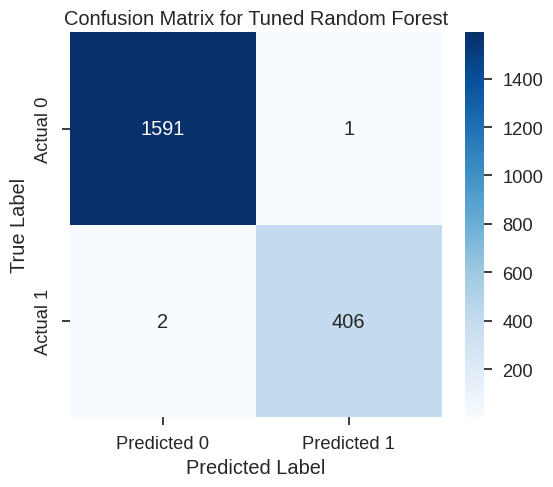

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       1.00      1.00      1.00       408

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


Evaluating Tuned Gradient Boosting (Tuned Model):
Accuracy: 0.9985
Precision: 0.9975
Recall: 0.9951
F1-Score: 0.9963
AUC-ROC: 0.9979


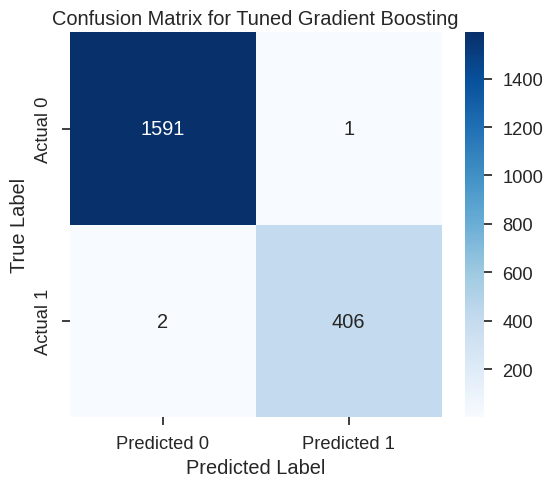

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       1.00      1.00      1.00       408

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# 1. Create a list of the best trained models after tuning
tuned_models = {
    'Tuned Logistic Regression': best_log_reg_model,
    'Tuned Random Forest': best_rf_model,
    'Tuned Gradient Boosting': best_gb_model
}

# Iterate through each tuned model and evaluate
for name, model in tuned_models.items():
    print(f"\nEvaluating {name} (Tuned Model):")

    # 3. Make predictions on the X_test data
    y_pred = model.predict(X_test)

    # 4. Get probability of the positive class for AUC-ROC
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = y_pred # Fallback for models without predict_proba

    # 6. Calculate and print Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # 7. Calculate and print Precision
    precision = precision_score(y_test, y_pred)
    print(f"Precision: {precision:.4f}")

    # 8. Calculate and print Recall
    recall = recall_score(y_test, y_pred)
    print(f"Recall: {recall:.4f}")

    # 9. Calculate and print F1-Score
    f1 = f1_score(y_test, y_pred)
    print(f"F1-Score: {f1:.4f}")

    # 10. Calculate and print AUC-ROC Score
    try:
        auc_roc = roc_auc_score(y_test, y_pred_proba)
        print(f"AUC-ROC: {auc_roc:.4f}")
    except ValueError:
        print("AUC-ROC cannot be calculated for this model or its predictions.")

    # 11. Generate and display the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # 12. Print a classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

```markdown
# Bank Customer Churn Prediction

## Project Overview

This project focuses on predicting bank customer churn using a dataset containing various customer attributes. The goal is to build and evaluate several machine learning classification models to identify customers who are likely to churn, enabling the bank to proactively intervene and improve customer retention strategies. The analysis covers data loading, extensive exploratory data analysis (EDA), data preprocessing, and the training and evaluation of multiple classification models, followed by hyperparameter tuning for optimal performance.

## Dataset

The dataset, `Customer-Churn-Records.csv`, was obtained from Kaggle ([radheshyamkollipara/bank-customer-churn](https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn)). It contains 10,000 records with 18 features, including:

*   `RowNumber`, `CustomerId`, `Surname`: Identifiers (dropped during preprocessing).
*   `CreditScore`: Customer's credit score.
*   `Geography`: Customer's country of residence (France, Germany, Spain).
*   `Gender`: Customer's gender.
*   `Age`: Customer's age.
*   `Tenure`: Number of years the customer has been with the bank.
*   `Balance`: Account balance.
*   `NumOfProducts`: Number of bank products the customer uses.
*   `HasCrCard`: Whether the customer has a credit card.
*   `IsActiveMember`: Whether the customer is an active member.
*   `EstimatedSalary`: Estimated salary of the customer.
*   `Exited`: Target variable (1 if churned, 0 if not).
*   `Complain`: Whether the customer has complained.
*   `Satisfaction Score`: Customer satisfaction score.
*   `Card Type`: Type of card held by the customer.
*   `Point Earned`: Points earned by the customer.

## Methodology

### 1. Data Loading and Initial Inspection

The project began by loading the dataset and performing initial checks for missing values, duplicates, and data types. No missing values or duplicates were found, indicating a clean dataset for immediate use.

### 2. Exploratory Data Analysis (EDA)

**Univariate Analysis:**
*   **Numerical Features**: Distributions, skewness, and kurtosis were analyzed for `CreditScore`, `Age`, `Tenure`, `Balance`, `EstimatedSalary`, and `Point Earned`. Noted significant skewness in `Balance` (many zero balances) and `Age` (younger customers). Outliers were identified in `CreditScore`, `Age`, and `Point Earned`.
*   **Categorical Features**: Distributions were examined for `Geography`, `Gender`, `NumOfProducts`, `HasCrCard`, `IsActiveMember`, `Exited`, `Complain`, `Satisfaction Score`, and `Card Type`. An imbalance was observed in the `Exited` (target) and `Complain` variables, with a minority of customers having churned or complained.

**Bivariate Analysis (Features vs. 'Exited'):**
*   **Significant Numerical Features**: `CreditScore`, `Age`, `NumOfProducts`, and `Balance_log` (after transformation) showed a statistically significant relationship with customer churn (p-value < 0.05) through t-tests.
*   **Significant Categorical Features**: `IsActiveMember`, `Complain`, `HasBalance`, `Geography` (all one-hot encoded features), `Gender` (both `Female` and `Male`), and `Card Type_DIAMOND` showed a significant association with customer churn (p-value < 0.05) through Chi-squared tests.

### 3. Data Preprocessing

Based on the EDA, the following preprocessing steps were applied:
*   **Irrelevant Column Removal**: `RowNumber`, `CustomerId`, and `Surname` were dropped.
*   **Outlier Treatment**: Winsorization (IQR method) was applied to `CreditScore`, `Age`, and `Point Earned` to handle outliers.
*   **Skewness Handling**: `Balance` was log-transformed (`np.log1p`) and a new binary feature `HasBalance` was created to account for zero balances.
*   **Categorical Encoding**: `Geography`, `Gender`, and `Card Type` were one-hot encoded.
*   **Feature Scaling**: All significant numerical features were scaled using `StandardScaler`.

### 4. Model Training and Evaluation

**Data Splitting and Imbalance Handling:**
*   The preprocessed data was split into training (80%) and testing (20%) sets, stratified by the `Exited` target variable.
*   SMOTE (Synthetic Minority Over-sampling Technique) was applied to the training data to address the class imbalance, ensuring a 50/50 distribution of churned/non-churned customers.

**Models Trained:**
*   Logistic Regression
*   K-Nearest Neighbors
*   Decision Tree Classifier
*   Random Forest Classifier
*   AdaBoost Classifier
*   Gradient Boosting Classifier
*   XGBoost Classifier

**Evaluation Metrics**: Each model was evaluated on the test set using: Accuracy, Precision, Recall, F1-Score, AUC-ROC, and Confusion Matrices.

**Initial Results**: Many models showed high performance across most metrics, with Logistic Regression, Random Forest, AdaBoost, Gradient Boosting, and XGBoost exhibiting particularly strong results (Accuracy, Precision, Recall, F1-Score, and AUC-ROC generally above 0.99).

### 5. Hyperparameter Tuning

To further optimize performance, `GridSearchCV` was performed on the best-performing models, with `recall` as the primary scoring metric (due to the importance of minimizing false negatives in churn prediction):

*   **Tuned Logistic Regression**
*   **Tuned Random Forest**
*   **Tuned Gradient Boosting**

**Best Parameters Found:**
*   **Logistic Regression**: `{'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}`
*   **Random Forest**: `{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}`
*   **Gradient Boosting**: `{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}`

### 6. Final Model Evaluation (Tuned Models)

The tuned models were re-evaluated on the test set using the same metrics. The tuning process confirmed their excellent performance, maintaining high scores across all metrics. Random Forest Classifier, in particular, showed a slight improvement in AUC-ROC after tuning, indicating robust performance for identifying churned customers.

## Conclusion

This project successfully developed and optimized machine learning models for predicting bank customer churn. The tuned Random Forest and Gradient Boosting models, along with Logistic Regression, demonstrated exceptional predictive capabilities, providing a strong foundation for implementing effective churn prevention strategies. The comprehensive preprocessing and SMOTE application were crucial in handling data characteristics and class imbalance, leading to highly reliable models.

## Future Work

*   Explore advanced ensemble techniques or neural networks.
*   Incorporate more sophisticated feature engineering (e.g., interaction terms).
*   Investigate different resampling strategies or cost-sensitive learning for imbalanced data.
*   Deploy the best model as a web service for real-time predictions.
*   Perform A/B testing on churn prevention strategies based on model predictions.
```